# 목차



##### 1단계 : 문제정의와 가설설정
1. 문제정의와 가설설정
2. 성능측정지표 설정

##### 2단계 : 자료수집과 정제
1. 연구계획수립 및 자료수집     
2. 자료준비\
    - 탐색적 데이터 분석(Exploring Data Analysis), 자료형Dtype.canvas|자료형 확인\
    - 결측치처리  \
    - 가변수화\
    - 스케일링\
    - 변환파이프라인 설정
1. 데이터분할 
    - 교차검정데이터세트 분할\
    - 임의성 및 대표성 확인\
    - 클래스불균형 확인
##### 3단계 : 탐색적 데이터 분석(Exploring Data Analysis)
1. 일변량 데이터(X, y) 탐색    \
    - 분포확인, 기술통계량 측정과 시각화	\
    - 종속변수(y) 정규성 확인\
    - 특이값 확인
  
2. 2변량 데이터(X~X, y~X) 탐색\
    - 분포확인, 기술통계량 측정과 시각화\
    - 상관계수 분석    \
    - 편잔차분석    
##### 4단계 : 자료가공(wrangling)과 데이터준비(preparation)
1. 자료가공\
    - 범주형 변수 인코딩\
    - 특성공학 : 스케일링과 스트럭쳐링
2. 특성선택
##### 5단계 : 모델구체화 
1. 선형모델
2. 다항회귀모델
4. 기계학습\
    - 비지도학습 : 의사결정나무, KNN\
    - 인공신경망모형 : DNN\
    - 지도학습 : 랜덤포레스트
5. 회귀해석
6. 회귀진단 
7. 모델성능개선 

#### 임포트


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

c:\Users\ENVY360\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1단계 : 문제정의와 가설설정
1. 문제정의와 가설설정
2. 성능측정지표 설정

## 1. 문제정의와 가설설정

**( 현재는 kaggle에서 제공하는 샘플과 문제정의를 그대로 적용하여 모델을 생성하는 것이므로 이 과정이 필요없을 수 있습니다. 하지만 그렇지 않은 경우라고 가정하고 문제정의와 가설설정단계를 진행하여 보았습니다.)**

1. 문제정의
- **목적** : 보스턴의 부동산 가격 예측 (회귀문제)
- **사용주체** : 부동산 매수매도와 관련된 모든 이해관계자 (투기업자, 건설사, 시행사, 부동산 등)
- **온라인/배치학습** : 배치학습
- **학습기반 (사례기반학습/모델기반학습)** : 모델기반
- **성능측정지표 (Metric)** : log scale RMSE (kaggle 제공)
- **출력 결과물** : ID 별 부동산 가격 예측값
- **기계학습 활용의 당위** : 건물의 명세정보를 이용한 (욕조 수 등) 대형회귀모델 구축 필요 (기존 부동산 가격 책정법과 상이한 방식의 접근)<br>


2. 가설설정

	**1) 사전탐색**
	- 참고할만한 전문가와 전문서적 : kaggle
	- 유사문제 : 주가예측
	- 대안데이터
	  - 유사상품거래가, 현금흐름할인법, 원가접근법 등을 활용한 부동산감정평가서 및 가장 최근 실거래가
	    
	**2) 정보 종합**
	- 주요 가격결정요소 : 1)위치, 2)대지면적, 3)건물의 건설일, 4)건물용도
	- 부동산 상품 성격
		- 투기적 성격 : 
			- 부동산 투기시장의 영향을 받아 불확실성을 가진다. (거래시기 중요)
			- 또는, 너무 높은 가격의 경우 건물명세만으로는 이해하기 어려울 수 있다.
		- 레버리지 : 부동산 매수에는 레버리지가 동반되므로 금리 정책이 영향
		- 정책적 상품 : 부동산은 국민주거안정과 연관, 국가부동산정책이 크게 영향 (정책입안에 따른 Structural Shift의 가능성)
		- 구성요소 중요 : 동일면적에 대한 구성요소의 변화가 가격에 영향을 미친다. 
	
	**3) 가설 설정**
		"1) 위치, 2) 대지면적, 3) 건물의 건설일, 4) 건물용도 5) 건물거래시점 5) 부동산 구성요소는 주택가격에 [[통계적으로 유의미]]한 영향을 미친다."
		* 외부샘플에 대한 예측이 목적이므로 가설검정을 위한 가설이 아닌 [[변수선택]]과 [[모델선택]]을 위한 가설설정이다.

## 2.성능측정지표 설정

**성능측정지표 : log-scale RMSE**\
1. $RMSE\,=\,\sqrt{\Sigma{\frac{(\hat{y_i}-y_i)^2}{n}}}$\
2. 특징
    - 거리 기반 성능측정지표\
    - 특이치 민감\
    - 스케일링 요구

# 2단계 : 자료수집과 자료준비
1. 연구계획수립 및 자료수집     
2. 자료준비
    - 자료형 확인 
    - 결측치처리  
    - 가변수화
    - 스케일링
    - 변환파이프라인 설정
1. 데이터분할 
    - 교차검정데이터세트 구축
    - 임의성 및 대표성 확인
    - 클래스불균형 확인

## 1. 연구계획수립 및 자료수집

**1) 필요자료 목록** : 가설설정에 따라, 아래 자료들이 필요합니다.\
-  위치
-  대지면적
-  건물의 건설일
-  건물용도
-  건물거래시점
-  부동산 구성요소

**2) 자료원천 : 웹 (kaggle)**
- 출처 : kaggle competition (House Prices - Advanced Regression Techniques) (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) (원출처 : ASA;American Statistical Association 의 데이터를 일부 가공)

**3) 수집방법** : csv 파일 직접 로컬 다운로드

**4) 수집** : 아래의 코드를 따름
1. 1460개의 훈련샘플, 1459개의 테스트 샘플로 구성되어 있습니다.
2. 특성의 갯수는 81개로 표시되었지만 종속변수인 "SalePrice" 와 인덱스인 "Id"를 제외하면은 독립변수는 79개입니다.
    - ID는 인덱스 데이터프레임을 곧바로 설정하였으며 해당 내용을 변환파이프라인에 포함하였습니다.
    - 변수 중 1) 이해할 수 없거나 2) 수집기준이 모호하거나 3) 일부 클래스가 과도하게 희박하여 회귀예측 모델에 도움이 되지 않을 것으로 판단되는 경우에는 제거합니다. (이해할 수 없지만 통계적 유의미성을 가지는 이유로 모두 포함할 경우 데이터 스누핑의 문제를 발생시킬 수 있습니다.)
    - 변환파이프라인은 테스트샘플에 적용하여 설정한 모델을 적용하기 위해 필요합니다.
3. 수집된 데이터 중 진행하는 문제정의에 부합하지 않는 경우는 삭제합니다.
    - 이번의 경우, 가족 간의 거래 등 주택거래가격책정엗 주택특성 외적 요소가 개입되는 경우에는 제거합니다.
    - 이러한 레코드들은 큰 잔차오류를 발생시키는 특이값이 될 수 있고 모델학습에 악영향을 미칠 수 있습니다.


3. 데이터타입은 ojbect(43), 정수형(26), 실수형(11) 개입니다.
    - 변수의 자료형에 따라 데이터 처리방법이 상이하기 때문에 변수명을 개별 리스트에 저장한다.
    - 정수형 데이터의 경우 수치형 자료 외 범주형 자료도 포함될 수 있습니다.
    - 이 경우, 정수로 표현된 class간의 수치간격을 조정해야할 필요성, 또는 명목형 범주데이터일 경우 one-hot-encoding을 진행하기 위해 수치형자료로부터 구별해야 합니다.
4. 데이터분할 : 
    - 원래라면 전체샘플을 수집한 후 (훈련 : 테스트) = (80 : 20) 정도의 비율로 데이터분할 공정을 거쳐야 합니다. 
    현재는 kaggle의 데이터분석 예제를 풀이하는 것이므로 과제제출을 위해 제공된 데이터분류를 그대로 따릅니다.
    - 하지만 이 경우에도 CrossValidation Set를 분리해낼 생각입니다. 필요한 모델의 튜닝을 위해서는 임식적인 테스트샘플의 역할을 해 줄 샘플이 필요합니다.
    - 이 라인 이후의 모든 데이터 가공은 훈련샘플에만 적용하되 변환파이프라인을 구축하여 동일한 가공을 테스트샘플에도 수행합니다.    

In [2]:
# 캐글로부터 보스턴시에 대한 주택데이터 다운로드
X_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
y_test = pd.read_csv("sample_submission.csv")
df_test= pd.concat([X_test,y_test.drop("Id", axis=1)],axis=1)

df_train_copy = df_train.copy() # 훈련샘플의 카피본

# 레코드 확인
display("Train Set :", df_train.head(3))
display("Test Set :", X_test.head(3))
display("Train Set :", y_test.head(3))

print("1. Train set size : ", len(df_train))
print("2. Test set size: ", len(X_test))
print("3. The Number of feature (train) : ", len(df_train.columns))
print("4. The Number of feature (test ): ", len(X_test.columns))
display("5. number of features for each dtypes : ", pd.DataFrame(X_test.dtypes.value_counts()))
print("6. The list of feats and dtypes is below : \n", df_train.dtypes)

'Train Set :'

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]

'Test Set :'

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  

[3 rows x 80 columns]

'Train Set :'

Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570

1. Train set size :  1460
2. Test set size:  1459
3. The Number of feature (train) :  81
4. The Number of feature (test ):  80


'5. number of features for each dtypes : '

0
object   43
int64    26
float64  11

6. The list of feats and dtypes is below : 
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


- 인덱스조정

In [3]:
# 처리1 : Id를 인덱스로 설정
def index_changer(df) :
    df.set_index("Id", inplace=True)
    return df

df_train.set_index("Id", inplace=True)
display("check new index : ", df_train.head(1))

'check new index : '

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  

[1 rows x 80 columns]

- 파이프라인 생성

추정한 모델을 테스트샘플에도 동일하게 적용하기 위해서는 파이프라인을 구축해두어야 합니다.

In [4]:
# 변환파이프라인 생성
pipeline = []
pipeline.append(index_changer)

- 자료형 확인 및 리스트 저장
    - 정수형 데이터 중 수치형 데이터라면 희귀값이 많을 것입니다. 대조적으로 순위를 가진 범주형 데이터라면 희귀값의 갯수가 적을 것입니다. 이 아이디어에 착안하여 포함하는 희귓값이 적은 정수형 데이터부터 살펴서 범주형 데이터 여부를 판단합니다.

    - 확인 결과 수치형 데이터 중 'MSSubClass'는 범주형 데이터로 분류합니다.

    - 수치형데이터 중 'Qual' 또는 'Cond'를 포함하는 변수들도 범주형 데이터에 해당하지만, 1의 간격을 가지는 정수형으로 표기되어 있으므로 분리하지 않았습니다.

In [5]:
# 변수리스트 저장
dependent = ["SalePrice"] # 종속변수
feats = list(df_train.drop(dependent, axis=1).columns) # 독립변수
feats_c = list(df_train.dtypes[df_train.dtypes==object].index) # 범주형 변수 
feats_n = list(df_train.drop(dependent, axis=1).dtypes[df_train.dtypes!=object].index) # 수치형 변수

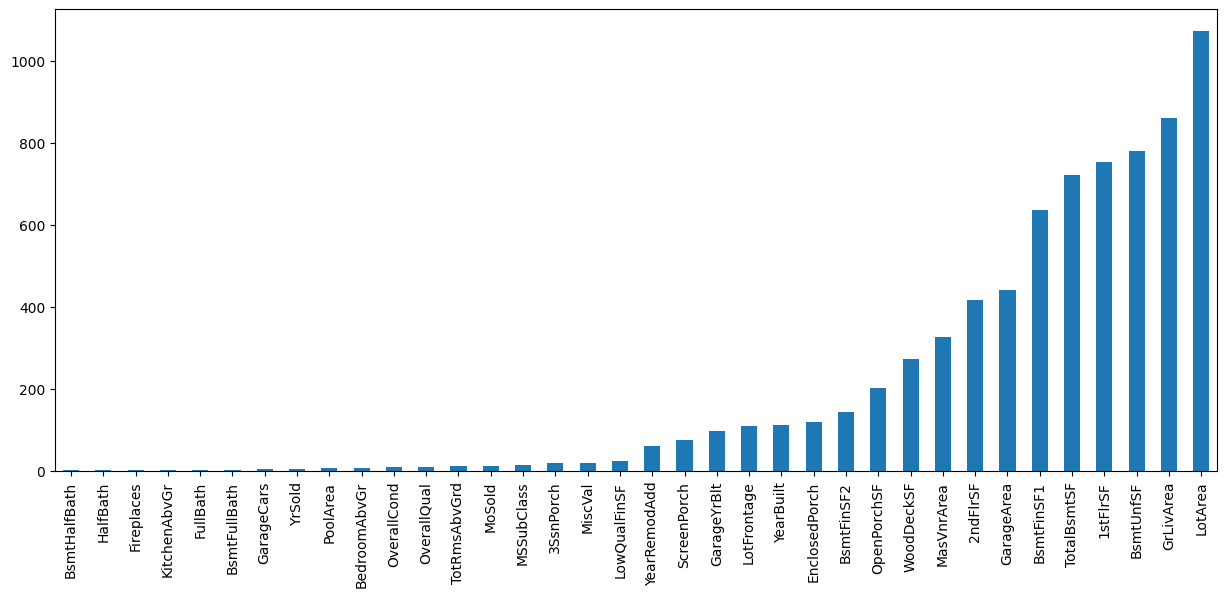

In [6]:
# 정수형 데이터의 중복을 제외한 희귀값의 갯수 시각화
fig = pd.Series([len(df_train[i].value_counts()) for i in feats_n], feats_n).sort_values().plot.bar(figsize=(15,6))

In [7]:
# 처리2 : "MSSubClass" 를 수치형에서 범주형특성 으로 이동
trans = ["MSSubClass"]

print("BEFORE : \n", df_train.dtypes.value_counts())
feats_n.remove(trans[0])
feats_c=feats_c+trans
df_train[trans] = df_train[trans].astype("object")
print("AFTER : \n", df_train.dtypes.value_counts())
#
def type_changer(df) :
    df[trans] = df[trans].astype("object")
    return df

pipeline.append(type_changer)

BEFORE : 
 object     43
int64      34
float64     3
dtype: int64
AFTER : 
 object     44
int64      33
float64     3
dtype: int64


- 변수 제거

'Utilities', 'MiscVal'은 자료설명을 참고하고도 이해할 수 없으며 충분히 향후 데이터의 수집 기준이 변경될 수 있는 데이터라고 판단되어 삭제조치 하였습니다. 

In [8]:
#처리 2-1 : 일부 변수 삭제
want_to_delete = ['MiscFeature', 'MiscVal', 'SaleType', 'Utilities']
for i in want_to_delete :
    try :
        feats.remove(i)
    except  Exception as e:
        pass
    try :
        feats_c.remove(i)
    except  Exception as e:
        pass
    try :
        feats_n.remove(i)
    except  Exception as e:
        pass

def deleting_features(df):
    df = df.copy()
    df = df[feats + ["SalePrice"]]
    return df

# 적용
df_train = deleting_features(df_train)
# 파이프라인 추가
pipeline.append(deleting_features)

- 레코드 삭제

    * 'SaleCondition'이 Abnormal, Family의 경우 우리가 예측하고 싶은 대상이 아닙니다.
    * 연구대상은 일반적인 경우이므로 이런 경우에 대해서는 Segment를 분류하여 회귀분석을 진행하거나 삭제하여 연구의 대상이 되는 타겟에 대한 회귀모델에 악영향을 미치지 않도록 하여야 합니다.

    * 이번 연구에서는 삭제 조치하였습니다.

In [9]:
# 처리 2-2 :  레코드 삭제

def deleting_abnormal_sale(df) :
    df = df.copy()
    df = df[df["SaleCondition"] !='Abnormal']
    df = df[df["SaleCondition"] !='Family']

    return df

df_train = deleting_abnormal_sale(df_train)
pipeline.append(deleting_abnormal_sale)


- 자료형 확인 결과 표시

    - 범주형 데이터의 분리 :범주형 데이터는 가변수화 과정이 상이하므로 명목형과 순위가 있는 순서형으로 세부분류 합니다. (수작업)
    - 삭제 및 변환 결과 : 총 변수 75개 (수치형 34개, 범주형 41개 (순서가 없는 범주형 변수 23개, 순서가 있는 범주형 변수 18개))


In [10]:
# 범주형 변수 중 순서가 있는 변수는
feats_c_r =['LotShape', 'LandSlope', 'Neighborhood', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'SaleCondition']
# 범주형 변수 중 순서가 없는 변수는
feats_c_nr = [i for i in feats_c if i not in feats_c_r]


print("The Number of feature (Total) : ", len(feats))
print("The Number of feature (Numerical) : ", len(feats_n))
print("The Number of feature (Categorical with rank) : ", len(feats_c_nr))
print("The Number of feature (Categorical without rank) : ", len(feats_c_r))

The Number of feature (Total) :  75
The Number of feature (Numerical) :  34
The Number of feature (Categorical with rank) :  23
The Number of feature (Categorical without rank) :  18


- 가변수화
    - 회귀계수를 가지는 식으로 모델링 하기 위해 범주형 데이터는 가변수화(Encoding) 작업을 수행합니다.
        - 일반적으로 명목형 변수의 경우 OntHotEncoding, 순서형 변수의 경우 OrdinalEncoding을 수행합니다.
        - 하지만, 이번 분석에서는 명목변수 또한  Ordinal Encoding 을 수행하였습니다.
        - 장점은, 변수 갯수가 과도하게 증식하는 것을 방지하고 분석이 간단하다는 것입니다.
        - 단점은, 이 경우 더미변수별로 회귀계수가 설정되는 것이 아니라, 클래스 별로 동일 회귀 계수에 대해 정수비율의 차이를 목적변수에 미치게 된다는 맹점이 있습니다.
    - 사전 레코드 정렬 : 명목형 변수에 대해 Ordinal Encoding을 진행하기 위하여, 각 변수의 클래스 별로 SalePrice에 대한 중위값을 기준으로 정렬합니다.
        - sklearn의 OrdinalEncoder 데이터프레임에서 이름이 빠르게 등장하는 순서대로 가변수를 진행하기 때문입니다.
        - 또한, seaborn을 이용하여 상자그림을 그리게 되면 알파벳 순서대로 그래프가 그려지므로, 변수에 따라 종속변수의 변화를 보기 편하다는 장점이 있습니다.
    - 가변수화 작업은 이 다음 단계로 진행될 KNNImputer를 활용하기 위해서도 필요한 단계입니다.
    - 가변수화를 진행한 데이터는 _encoded 로 따로 저장합니다.
        - EDA를 진행하기 위해 원자료를 유지할 필요성이 있습니다.
        

- 결측치처리

    - 결측치는 무작위 결측치와 비무작위 결측치로 구분.
        - 비무작위 결측치
            - 비무작위 결측치는 동일 시설물에 대한 다른 변수로부터 정보를 얻어 수작업으로 채운다.
            - 이번 프로젝트에서 비무작위 결측의 대표적 이유는 해당 시설물 미보유 시 해당 값이 결측되어 있는 경우이다.
            - Basement, Kitchen, FirePlace, Garage, POrch, Pool, Lot의 경우 각 시설물에 해당하는 수치데이터를 이용하여 미보유시 "unowned"로 채운다.

        - 무작위 결측
            - 무작위 결측치는 KNN 알고리즘을 활용
            - 평균 또는 중위값 등을 이용하여 채울 경우 편향이 발생할 우려가 높습니다.

    - 결측치가 너무 많을 경우 해당 변수 또는 레코드를 제거하는 것을 고려할 수 있다.\

In [11]:
# 카테고리의 갯수에 해당하는 알파벳 리스트를 반환해주는 제너레이터
def generate_alphabet_list(a):
    alphabet_list = []
    start_char = ord('A')  # 'A'의 ASCII 코드

    for i in range(len(a)):
        if start_char > ord('Z'):
            start_char = ord('A')  # 'Z'를 넘어가면 다시 'A'부터 시작
        alphabet_list.append(chr(start_char))
        start_char += 1  # 다음 알파벳으로 이동

    return alphabet_list

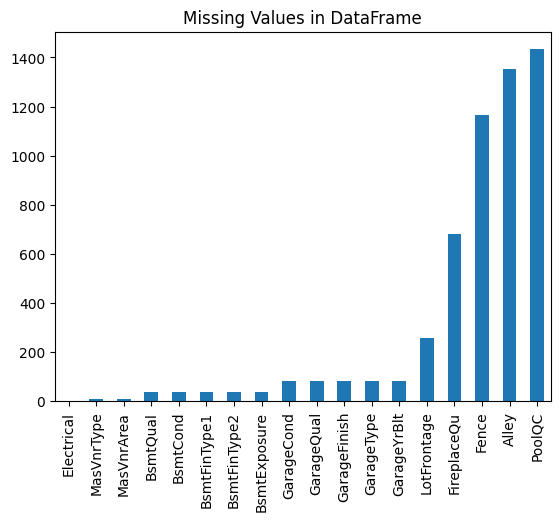

In [12]:
# 결측치 갯수 시각화
with_na = df_train.isna().sum()
with_na = with_na[with_na>0].sort_values()
with_na.plot.bar()
plt.title('Missing Values in DataFrame')
plt.show()

In [13]:
# 처리3 : (비무작위 결측) 참조할 변수가 있는 칼럼 수동으로 채우기
def manual_imputer(df) :  

    df = df.copy()
    # 수동입력 대상과 참조 변수 (동일 시설물에 대한 수량형 데이터)
    # 시설물 미보유에 따른 결측이 발생할 수 있는 시설물들
    manual_imputer = ["Bsmt", "Kitchen", "FirePlace", "Garage", "Porch", "Pool", "Lot"]
    # 보유여부를 확인할 수 있는 변수
    manual_filling_reference = ["TotalBsmtSF", "KitchenAbvGr","Fireplaces","GarageArea", "OpenPorchSF", "PoolArea", "LotArea"]

    for keyword, reference in zip(manual_imputer, manual_filling_reference) :
        try :
            idx = df[df[reference]==0].index
            temp_c = [i for i in feats_c if keyword in i]
            df.loc[idx,temp_c]=df.loc[idx,temp_c].fillna("Unowned")
        except Exception as e :
            continue

    return df


# 처리4 : (레코드 정렬) 부동산매도가격 중위값 기준 카테고리 넘버링
def numbering(df) :     
    df = df.copy()
    for cl in feats_c_nr+feats_c_r :
        temp = df[[cl , "SalePrice"]].groupby(by=cl).median().sort_values(by="SalePrice", ascending=True)
        for i, j in zip(temp.index, generate_alphabet_list(temp.index)) :    
            df[cl].replace(i,f"{j}. {i}", inplace=True) 
    return df

## 처리 5 : (무작위 결측) 가변수화 및 KNNImputer
def auto_imputer(df) :

    df = df.copy() 
    # 가변수화
    encoder = OrdinalEncoder()
    df[feats_c] = encoder.fit_transform(df[feats_c])

    # KNNImputer
    imputer = KNNImputer()
    df_encoded = imputer.fit_transform(df)
    df_encoded = pd.DataFrame(df_encoded, columns=df.columns, index=df.index)

    # 범주형 변수의 경우 정수로 반올림
    df_encoded[feats_c] = df_encoded[feats_c].applymap(lambda x : round(x,0))
    
    return df_encoded

In [14]:
#처리 3,4,5 적용
df_train = manual_imputer(df_train)
df_train = numbering(df_train)
df_train_encoded = auto_imputer(df_train)

###  누락값 재확인
print("Still have a Missing Value : ", df_train_encoded.isna().any().any())

Still have a Missing Value :  False


In [15]:
# 처리 3,4,5 pipeline에 추가
pipeline += [manual_imputer,numbering ,auto_imputer]

- 데이터분할
    - 과대적합을 피하는 모델학습방법에는 데이터 분할도 포함됩니다. 데이터 분할에는 K-Fold, 홀드아웃셋트 구성 등잉 있습니다.
    - 홀드아웃셋트는 연산량이 작아 초기모델을 평가하고 튜닝하는데 주로 사용합니다.
    - 수집한 데이터는 이미 Test sample이 분리되어 있는 상태이므로 CrossValidationSet만 분리하겠습니다.
    - CV세트가 필요한 이유는, 모델튜닝을 위해 테스트샘플의 오염을 회피하는 동시에, 테스트샘플 역할을 해 줄 세트가 필요하기 때문입니다.
    - 데이터분할에는 총 샘플에 대한 대표성을 확보해야합니다.
- 방법 : 훈련샘플의 뒷번부터 20%를 CV 샘플로 분할하겠습니다.
    - 해당방법은 테스트샘플의 분리방법과 동일합니다.
- 결과 : 1152개의 훈련샘플과 288개의 교차검증샘플이 분리되었습니다.

In [16]:
# 샘플분할 인덱스 확인
criterion = int(len(df_train) * 0.8)
print('size of train sample : ', criterion)
print('size of cv sample : ', len(df_train)-criterion)

# 분할
df_cv = df_train.iloc[criterion:,:].copy()
df_cv_encoded = df_train_encoded.iloc[criterion:,:].copy()
df_train = df_train.iloc[:criterion, :].copy()
df_train_encoded = df_train_encoded.iloc[:criterion, :].copy()

size of train sample :  1152
size of cv sample :  288


- 클래스불균형 확인

    - 범주형 독립변수의 클래스별 샘플의 숫자가 크게 차이날 경우, 레코드가 많은 집단의 특성이 모델 학습과정에서 높은 가중치를 가지게 되며 모델이 편향되게 하고 성능을 저하시킨다.
    - 가장 중요변수 중 하나로 가설설정 되었던 토지면적에 대해서 분석하였습니다.
        - 대표성 : test sample까지 합한 전체 표본의 비율과 훈련샘플의 비율이 크게 차이나지 않는다. 샘플링편향은 없는 것으로 생각됩니다.
        - 클래스불균형 : 토지면적에 대해서 5분위를 분리하고 (평균으로 부터 95% 범위 내 데이터에 대해서), 각 집단별로 수집된 비율을 확인한 결과 
        - 종속변수 segment 분리 필요성 : SalePrice의 분포를 확인한 결과 각 가격대별로 유사하게 샘플링 되어 segment를 구성할 필요성은 없을 것 같습니다.
        클래스별로 균형있게 수집되었다고 볼 수는 없을 것 같습니다.
    - 단, 일부 레코드들이 크게 레버리지되어 있는 모습을 확인할 수 있었으며 모델학습과정에서 특이값 및 영향값에 대한 확인이 필요함을 알 수 있다.    
    - 상당한 수준으로 클래스불균형을 보이고 있는 것을 확인할 수 있으며, 일부 segment를 분리할 필요가 있음을 알 수 있습니다.
    

- 샘플분할 결과확인
    - 결과 분할 된 두 샘플의 클래스별 포함비율은 유사하게 나타난 것으로 확인되어, 샘플분할과정에서 임의성이 확보된 것으로 판단됩니다.

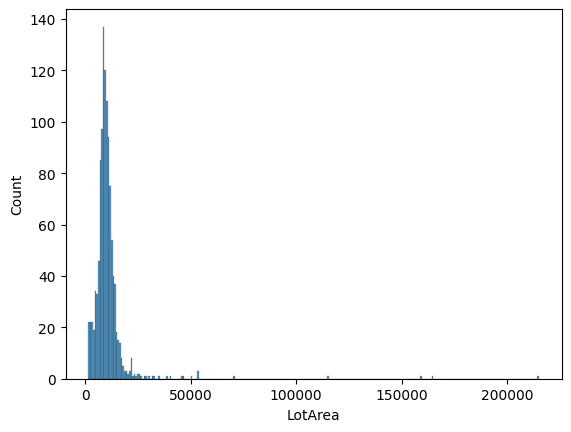

In [17]:
# 토지면적 시각화
fig = sns.histplot(df_train["LotArea"])

In [18]:
# 토지면적에 대해서 5개의 분위로 집단을 분리합니다.
print("각 집단별 포함 레코드 비율")
print(pd.qcut(df_train["SalePrice"], 5, [1,2,3,4,5]).value_counts()/len(df_train)*100)

각 집단별 포함 레코드 비율
1    20.225694
4    20.225694
3    19.965278
2    19.791667
5    19.791667
Name: SalePrice, dtype: float64


In [19]:
z = 1.96 # 95% 유의수준
mu = df_train["LotArea"].mean()
std = df_train["LotArea"].std()

upper = z * std + mu
lower = max(-z * std + mu, 0)

print("upper : ", upper)
print("lower : ", lower)

num_bins = 5


def class_imbalance(df, num_bins, variable) :

    df = df.copy()

    bins = [lower] + sorted([upper/i for i in range(1, 1+num_bins)]) + [np.inf]
    df[f"{variable}_cat"] = pd.cut(df[f"{variable}"], bins, labels=range(len(bins)-1))
    res = df[f"{variable}_cat"].value_counts()/len(df)

    return res

# 전체 데이터셋 생성
original = pd.concat([df_train, df_cv, df_test], axis=0)
 
# 분위별 포함 비율 확인
agg = []
for i in [original, df_train] :
    agg += [class_imbalance(i, num_bins, "LotArea")]

pd.DataFrame(agg, index=["original", "train_set"]).T.sort_index()

upper :  31599.36862264361
lower :  0


original  train_set
0  0.168679   0.161458
1  0.125905   0.125868
2  0.354260   0.356771
3  0.281821   0.289062
4  0.057951   0.052951
5  0.011383   0.013889

# 3단계 : 탐색적 데이터 탐색(Exploring Data Analysis)


1. 일변량 데이터(X, y) 탐색    
    - 기술적 통계량 : 평균, 변이
    - 히스토그램과 확률분포 
    - 종속변수(y) 정규성 테스트    
        

2. 2변량 데이터(X~X, y~X) 탐색
    - (피어슨, 스피어만) 상관계수 분석     
    - 비선형성 파악 : 잔차그림
    - 이상치, 영향값, 고레버리지 값 : 버블그림
    - 히스토그램과 확률분포 : 박스그림,바이올린 그림(범주형), 박스형 그림, 결합분포 
    - y~X : 결합 독립성 테스트 
    

## 1-1) 일변량 데이터(y) 탐색

1. 평균값에 비해 중간값이 작은 것으로 미루어, 오른쪽으로 긴꼬리를 조금 더 긴꼬리를 가진 것으로 보인다. : log스케일 변환
1. 10분위의 구분선들이 밀집되어 있는 것으로 미루어, 이상치의 크기가 매우 크다는 것을 알 수 있다.



- 분포확인 및 기술통계량 측정

Mean : $181,062 
Median : $163,700 
Standard Deviation : $79,075 
Max : $755,000 
Min : $34,900 
Decile(d1) : $106,000 
Decile(d2) : $124,000 
Decile(d3) : $135,500 
Decile(d4) : $147,640 
Decile(d5) : $163,700 
Decile(d6) : $179,615 
Decile(d7) : $200,000 
Decile(d8) : $230,000 
Decile(d9) : $279,350 
Decile(d10) : $755,000 


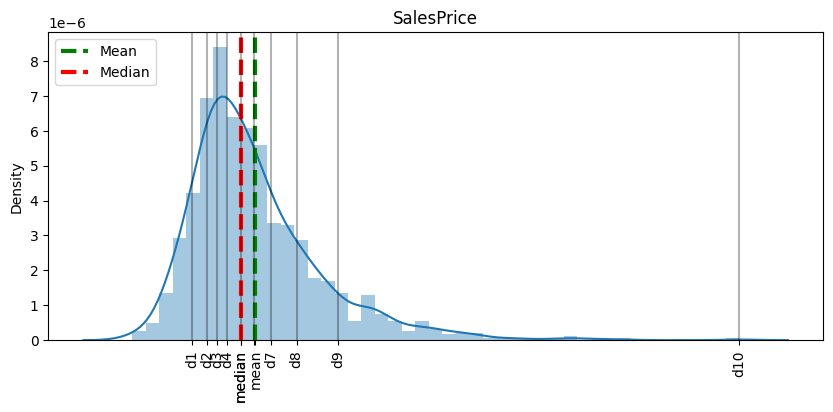

In [20]:
### 평균과 분산, 백분위수 계산
_mean = int(df_train["SalePrice"].mean())
_median =  int(df_train["SalePrice"].median())
_std = int(df_train["SalePrice"].std())
_min = int(df_train["SalePrice"].min())
_max = int(df_train["SalePrice"].max())


### 평균과 분산, 백분위수 출력
print(f"Mean : ${_mean:,.0f} ")
print(f"Median : ${_median:,.0f} ")
print(f"Standard Deviation : ${_std:,.0f} ")
print(f"Max : ${_max:,.0f} ")
print(f"Min : ${_min:,.0f} ")

plt.figure(figsize=(10,4))
sns.distplot(df_train["SalePrice"])
plt.axvline(_mean, color='green', linestyle='--', linewidth=3, label="Mean")
plt.axvline(_median, color='red', linestyle='--', linewidth=3, label='Median')
plt.tick_params(axis='x', labelrotation=90)
plt.title("SalesPrice")
plt.xlabel("")
plt.legend()

ticks = []

for i in range(10) :
    i += 1
    j = i/10
    d = df_train['SalePrice'].quantile(j)   
    ticks+=[d]
    print(f"Decile(d{i}) : ${d:,.0f} ")
    plt.axvline(d, color='black', linestyle='-', alpha=0.3)

plt.xticks([_mean,_median, *ticks], labels=["mean","","d1","d2","d3","d4","median","","d7","d8","d9","d10"])
plt.show()


- 로그변환 및 정규분포 확인
    - 종속변수의 정규성 확인은 전통통계의 기법을 활용하기 위해 요구되는 사항으로 회귀분석의 전제가 됩니다.
    - 로그변환을 통해 이전보다 정규분포에 가까운 모양을 가지게 되었습니다.
    - 로그변환 후에도 오른쪽 꼬리가 fatter하고 right-skewed 특성을 QQ-plot으로 알 수 있습니다.
    - 그러한 특이값과 영향값은 모델학습에 크게 영향을 미치기 때문에 cook-distance 등을 통한 진단 및 핸들링이 필요합니다.
    - 함수형태 확인 후 회귀진단 과정에서 특이값에 대한 핸들링을 진행하겠습니다.

Text(0, 0.5, '')

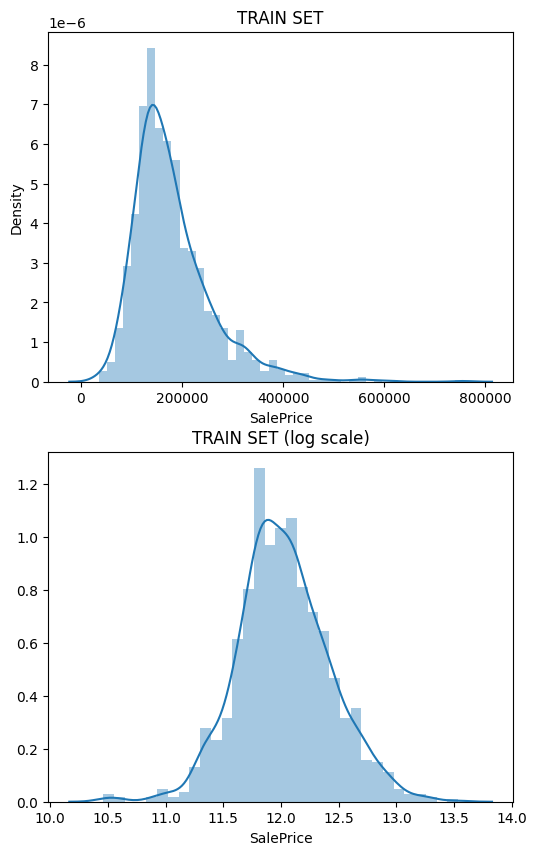

In [21]:
fig, axs = plt.subplots(2,1, figsize=(6,10))

### 시각화

# 원자료 
sns.distplot(df_train["SalePrice"], ax=axs[0])

# log변환 plot
sns.distplot(np.log(df_train["SalePrice"]), ax=axs[1])

# figure setting
axs[0].set_title("TRAIN SET")
axs[1].set_title("TRAIN SET (log scale)" )
axs[1].set_xlabel("SalePrice")
axs[1].set_ylabel("")

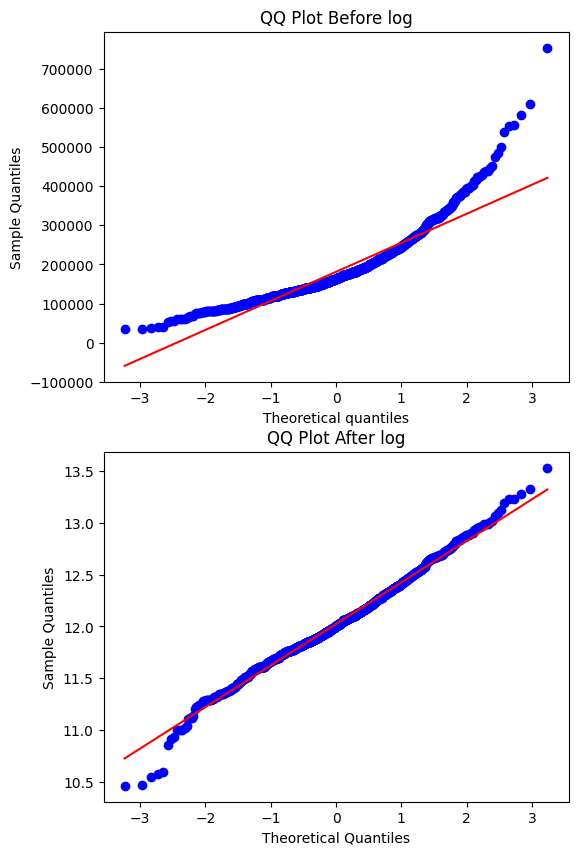

In [22]:
# QQ plot

# 예제 데이터 생성 (정규 분포를 따르지 않는 예시)
#data = np.log(df_train["SalePrice"].values)  # 지수 분포 데이터 생성



# QQ plot 그리기
fig, axs = plt.subplots(2,1,figsize=(6,10))
f1 = stats.probplot(df_train["SalePrice"].values, dist="norm", plot=axs[0])
f2 = stats.probplot(np.log(df_train["SalePrice"].values), dist="norm", plot=axs[1])
axs[0].set_title("QQ Plot Before log")
axs[1].set_title("QQ Plot After log")
axs[1].set_xlabel("Theoretical Quantiles")
axs[0].set_ylabel("Sample Quantiles")
axs[1].set_ylabel("Sample Quantiles")
plt.show()


# 약간 벗어나는 값들이 존재하는 것을 확인할 수 있음.
# 약간 오른쪽으로 기울어져 skewed되어 있는 꼴임을 확인할 수 있다.

In [23]:
# 처리 6 : 종속변수 y log 스케일화
 
def y_log(df, df_encoded) :
    df = df.copy()
    df_encoded = df_encoded.copy()

    df["SalePrice"] = np.log(df["SalePrice"])
    df_encoded["SalePrice"] = np.log(df_encoded["SalePrice"])

    return df, df_encoded

df_train, df_train_encoded = y_log(df_train, df_train_encoded)
df_cv, df_cv_encoded = y_log(df_cv, df_cv_encoded)

pipeline += [y_log]

## 1-2) 일변량 데이터(X) 탐색

### Numerical 변수 : 분포확인 및 기술통계량 측정

1. 값 '0'을 가지는 레코드가 굉장히 많다 : (희소클래스) 
- 희소클래스는 많은 레코드가 0의 값을 가지거나 변화가 거의 없는 경우로서 이 경우 포함하고 있는 정보의 양이 적어서 과대적합 문제가 발생할 수 있습니다.
- 희소클래스는 데이터증강, 삭제 등의 방법으로 핸들링이 가능하며 이 경우 변수의 갯수가 충분하기 때문에 삭제의 방법으로 핸들링하였습니다.
- 대상 : ['PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'LowQualFinSF', 'BsmtFinSF2', 'KitchenAbvGr' ]
2. 대부분 오른쪽으로 두꺼운 꼬리를 가지고 있다. : 로그스케일 변환 필요
- 대상 : 'GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','LotFrontage','GarageArea', 'BsmtUnfSF', 'TotalBsmtSF'
3. 0이하의 값에 대해 bound 되는 것 외에 상방에 대한 bound가 확인되지 않습니다.



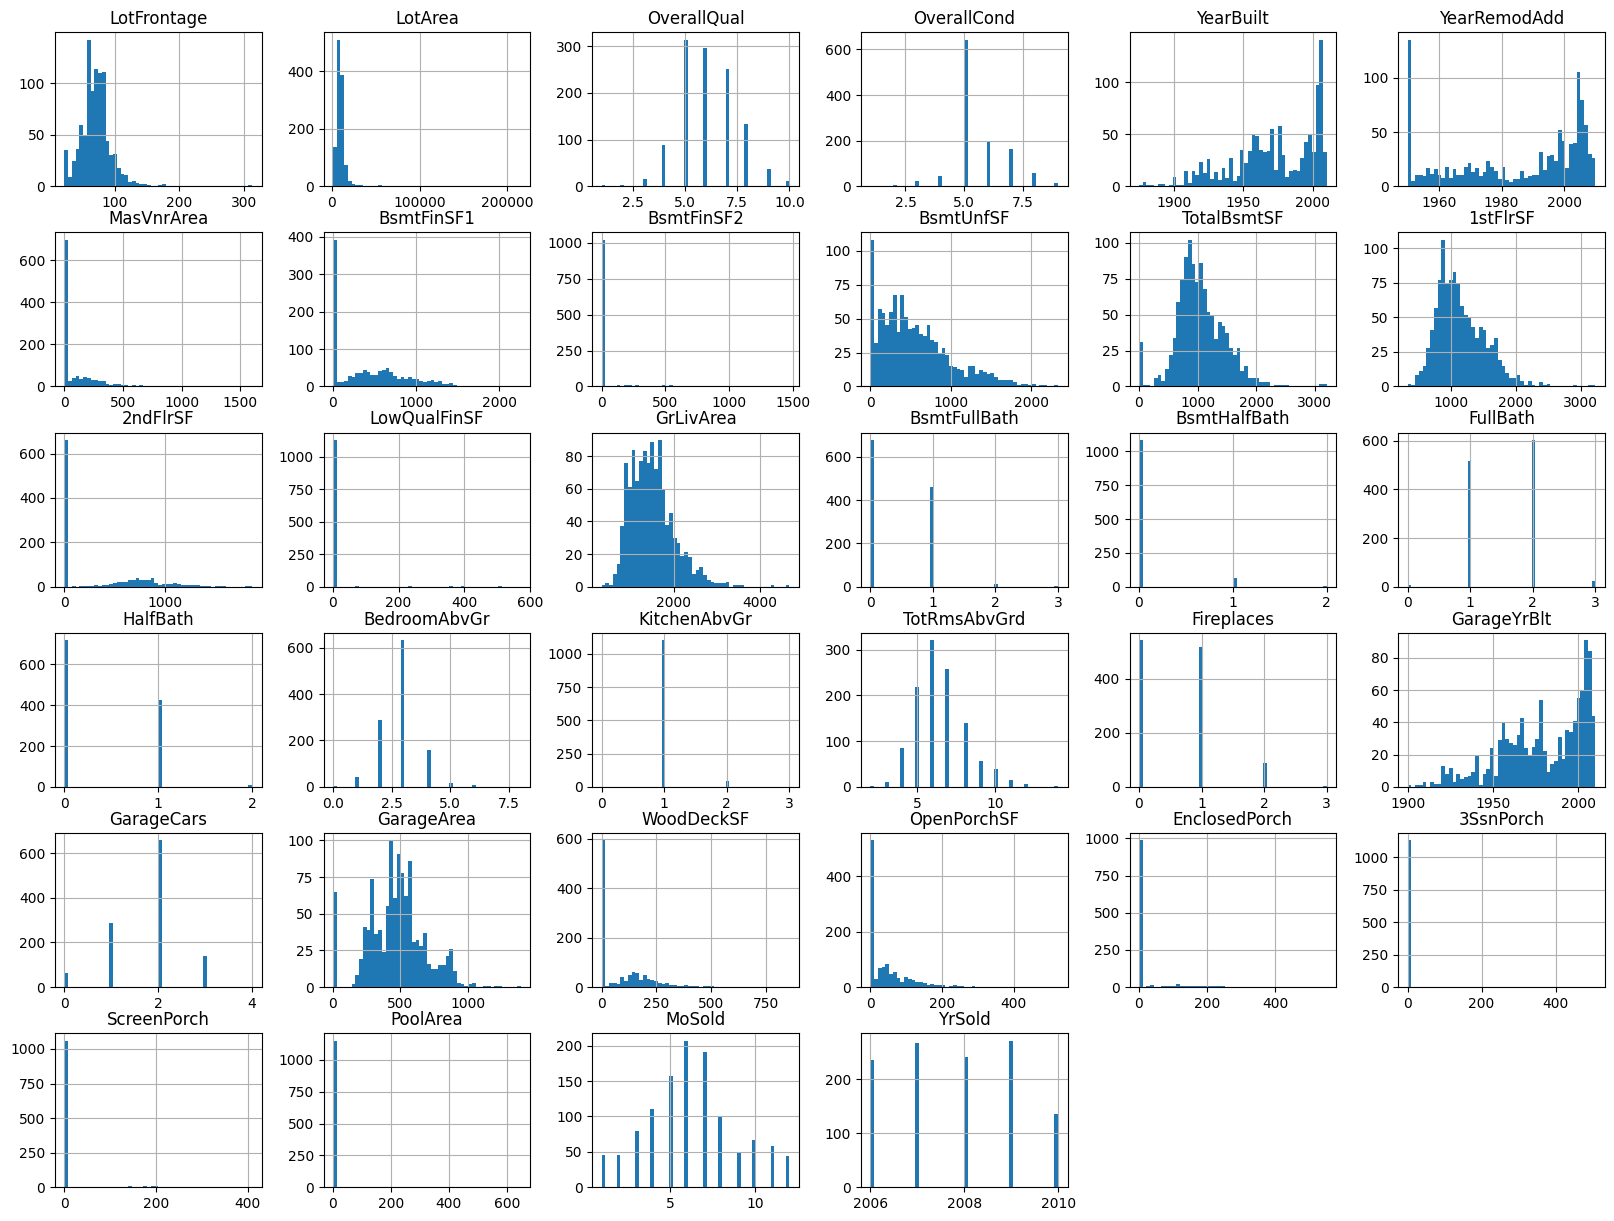

In [24]:
# 분포확인
df_train[feats_n].hist(bins=50, figsize=(20,15), )
plt.show()

In [25]:
sparse = ['PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'LowQualFinSF', 'BsmtFinSF2', 'KitchenAbvGr' ]

# 변수조정
feats = [i for i in feats if i not in sparse]
feats_c = [i for i in feats_c if i not in sparse]
feats_n = [i for i in feats_n if i not in sparse]
feats_c_r = [i for i in feats_c_r if i not in sparse]
feats_c_nr = [i for i in feats_c_nr if i not in sparse]

def drop_sparse(df, df_encoded, new_feats) :
    df = df.copy()
    df_encoded = df_encoded.copy()
    df =  df[new_feats+["SalePrice"]]
    df_encoded = df_encoded[new_feats+["SalePrice"]]
    
    return df, df_encoded
    
pipeline.append(drop_sparse)

In [26]:
# 기술통계량
df_train[feats_n].describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count   948.000000    1152.000000  1152.000000  1152.000000  1152.000000   
mean     69.930380   10538.545139     6.104167     5.572917  1971.486979   
std      23.326148   10745.318104     1.381113     1.124668    30.018700   
min      21.000000    1300.000000     1.000000     1.000000  1875.000000   
25%      59.000000    7555.000000     5.000000     5.000000  1954.000000   
50%      70.000000    9423.000000     6.000000     5.000000  1973.000000   
75%      80.000000   11616.000000     7.000000     6.000000  2000.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF  ...  \
count   1152.000000  1146.000000  1152.000000  1152.000000  1152.000000  ...   
mean    1985.115451   103.835951   441.764757   563.137153  1051.640625  ...   
std       20.511353   181.405534   433.719782   442.254522   419.313996  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000   222.250000   795.750000  ...   
50%     1994.000000     0.000000   384.000000   467.500000   998.500000  ...   
75%     2004.000000   167.750000   709.000000   797.250000  1297.250000  ...   
max     2010.000000  1600.000000  2260.000000  2336.000000  3206.000000  ...   

       BedroomAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   1152.000000   1152.000000  1152.000000  1087.000000  1152.000000   
mean       2.846354      6.480035     0.614583  1978.588776     1.763021   
std        0.819932      1.612705     0.643672    24.633168     0.740010   
min        0.000000      2.000000     0.000000  1900.000000     0.000000   
25%        2.000000      5.000000     0.000000  1961.000000     1.000000   
50%        3.000000      6.000000     1.000000  1980.000000     2.000000   
75%        3.000000      7.000000     1.000000  2002.000000     2.000000   
max        8.000000     14.000000     3.000000  2010.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF       MoSold       YrSold  
count  1152.000000  1152.000000  1152.000000  1152.000000  1152.000000  
mean    472.938368    94.778646    46.428819     6.289931  2007.830729  
std     211.309497   123.797727    65.743811     2.671594     1.316207  
min       0.000000     0.000000     0.000000     1.000000  2006.000000  
25%     336.000000     0.000000     0.000000     5.000000  2007.000000  
50%     478.000000     0.000000    24.000000     6.000000  2008.000000  
75%     576.000000   168.000000    68.250000     8.000000  2009.000000  
max    1390.000000   857.000000   523.000000    12.000000  2010.000000  

[8 rows x 27 columns]

### Categorical 변수 : 분포확인 및 기술통계량 측정

1. 희소클래스에 대해서는 수치형변수와 동일하게 처리하였습니다.
2. 수치형 자료와 동일하게 시설물을 가지고 있지 않은 경우 결측치로 표시된다.
    - 가변수화를 진행한 데이터셋 df_train_encoded 에서는 "unowned" 클래스를 수동으로 추가하여 결측치를 대신하였습니다.
3. 수치형 변수와 동일하게 희소한클래스의 문제가 존재하는 변수의 경우 삭제하였습니다.
    - 대상 : ["Street", "Condition2", "PoolQC","PavedDrive", "Heating", "RoofMatl"]
4. 가장 많은 클래스를 포함한 변수는 'Neighborhood'로, 24개의 클래스를 가지고 있습니다.
    - 클래스 갯수의 구분은 smoothing과 관련이 있으며 과도하거나 과소한 클래스의 구분은 데이터의 분포를 알기 어렵게 합니다.

In [27]:
# 각 범주별 클래스의 갯수
cats = pd.DataFrame([df_train[cl].sort_values().unique() for cl in feats_c], index=feats_c).fillna("").T
cats

MSZoning   Street    Alley LotShape LandContour   LotConfig LandSlope  \
0   A. C (all)  A. Grvl  A. Grvl   A. Reg      A. Bnk   A. Inside    A. Gtl   
1        B. RM  B. Pave  B. Pave   B. IR1      B. Lvl   B. Corner    B. Mod   
2        C. RH                     C. IR3      C. Low      C. FR2    C. Sev   
3        D. RL                     D. IR2      D. HLS      D. FR3             
4        E. FV                                         E. CulDSac             
5                                                                             
6                                                                             
7                                                                             
8                                                                             
9                                                                             
10                                                                            
11                                                                            
12                                                                            
13                                                                            
14                                                                            
15                                                                            
16                                                                            
17                                                                            
18                                                                            
19                                                                            
20                                                                            
21                                                                            
22                                                                            
23                                                                            
24                                                                            

   Neighborhood Condition1 Condition2  ... FireplaceQu  GarageType  \
0    A. MeadowV  A. Artery    A. RRNn  ...       A. Po  A. Unowned   
1     B. IDOTRR   B. Feedr  B. Artery  ...       B. Fa  B. CarPort   
2     C. BrDale    C. RRAe   C. Feedr  ...       C. TA   C. Detchd   
3    D. OldTown    D. Norm    D. RRAn  ...       D. Gd  D. Basment   
4    E. BrkSide    E. RRAn    E. Norm  ...       E. Ex   E. 2Types   
5    F. Edwards    F. RRNe    G. PosN  ...               F. Attchd   
6     G. Sawyer    G. PosN    H. PosA  ...              G. BuiltIn   
7    H. Blueste    H. PosA             ...                           
8      I. SWISU    I. RRNn             ...                           
9      J. NAmes                        ...                           
10   K. NPkVill                        ...                           
11   L. Mitchel                        ...                           
12   M. SawyerW                        ...                           
13   N. Gilbert                        ...                           
14    O. NWAmes                        ...                           
15   P. Blmngtn                        ...                           
16   Q. CollgCr                        ...                           
17   R. ClearCr                        ...                           
18   S. Crawfor                        ...                           
19   T. Veenker                        ...                           
20   U. Somerst                        ...                           
21    V. Timber                        ...                           
22   W. StoneBr                        ...                           
23   X. NoRidge                        ...                           
24   Y. NridgHt                        ...                           

   GarageFinish  GarageQual  GarageCond PavedDrive      PoolQC     Fence  \
0    A. Unowned       A. Po  A. Unowned       A. N  A.

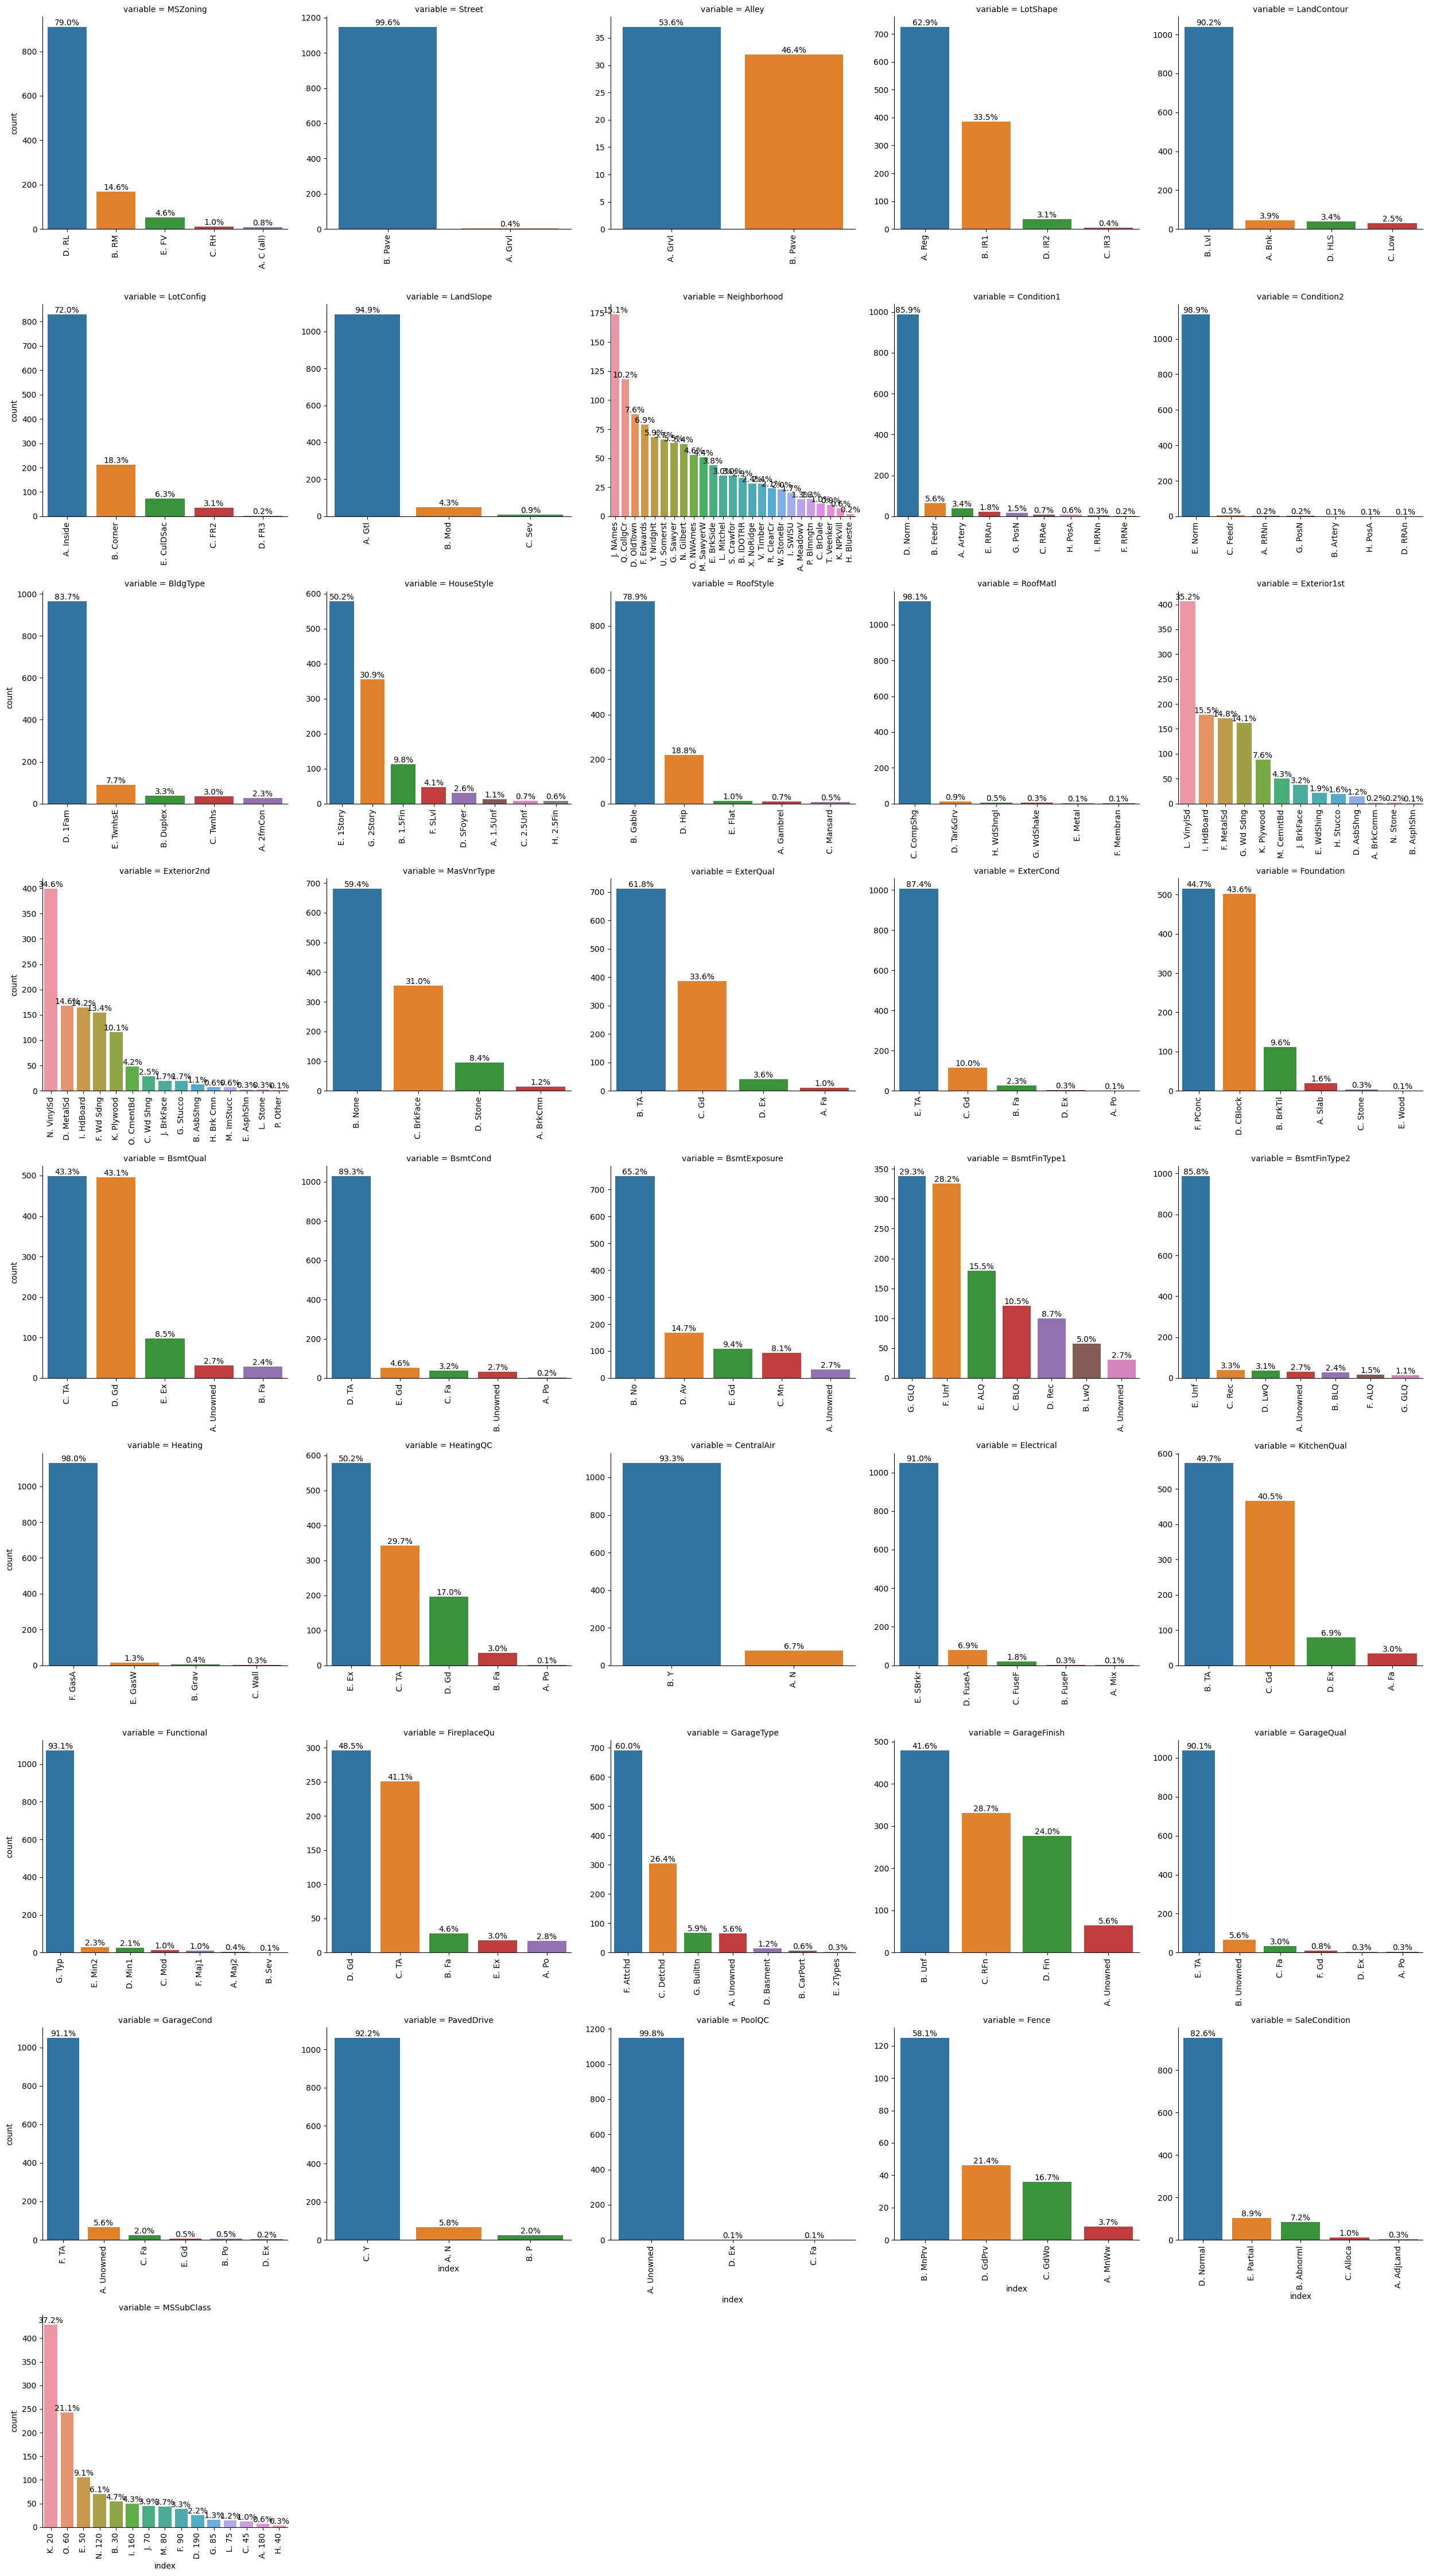

In [28]:
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=feats_c)
f.drop("SalePrice", inplace=True, axis=1)

sub_dfs = []

for i in feats_c :
    fron = pd.DataFrame(df_train[i].value_counts())
    fron.columns = ["count"]
    fron["variable"] = [i]*len(fron)
    sub_dfs.append(fron)

f = pd.concat(sub_dfs)
f.reset_index(inplace=True)

def barplot(x,y, **kwargs) :
    fig = sns.barplot(x,y)
    x = plt.xticks(rotation=90)
    for p in fig.patches :
        height = p.get_height()
        pct = p.get_height() / np.sum(y)*100
        _text = plt.annotate(f'{pct:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False, size=5)
g = g.map(barplot,"index","count")

In [29]:
# 희소클래스 제거
sparse += ["Street", "Condition2", "PoolQC","PavedDrive", "Heating", "RoofMatl"]

feats = [i for i in feats if i not in sparse]
feats_c = [i for i in feats_c if i not in sparse]
feats_n = [i for i in feats_n if i not in sparse]
feats_c_r = [i for i in feats_c_r if i not in sparse]
feats_c_nr = [i for i in feats_c_nr if i not in sparse]

df_train, df_train_encoded = drop_sparse(df_train, df_train_encoded, feats)
df_cv, df_cv_encoded = drop_sparse(df_cv, df_cv_encoded, feats)

## 2-1) Numerical 변수 확인 (X~X)

- 상관계수

1. 독립변수간에 선형상관성을 가질 경우 다중공선성의 문제를 야기할 수 있습니다.
- 다중공선성은 회귀계수의 해석을 어렵게합니다.
- 해당 변수들은 : 상호관계항을 생성

대상 : 
['ExterQual:OverallQual',             
'1stFlrSF:2ndFlrSF',           
'OverallQual:YearBuilt',           
'YearBuilt:GarageYrBlt',           
'GarageCond:GarageArea',          
'GarageQual:GarageArea']

<Axes: >

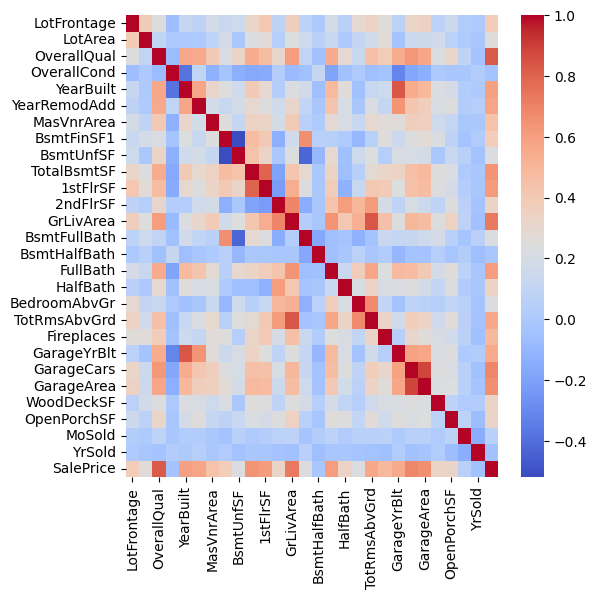

In [30]:
# 상관계수
plt.figure(figsize=(6,6))
corr = df_train[feats_n+["SalePrice"]].corr()
sns.heatmap(corr, cmap="coolwarm")

In [31]:
# 가장 높은 상관성을 보이는 상대
corr_agg = pd.DataFrame([corr[f"{i}"].nlargest(2).index[-1] for i in feats_n], index=feats_n, columns=["variable"])
corr_agg["corr"] = [corr[f"{i}"].nlargest(2).values[-1] for i in feats_n]
corr_agg

variable      corr
LotFrontage       1stFlrSF  0.417729
LotArea        LotFrontage  0.389686
OverallQual      SalePrice  0.822033
OverallCond   BsmtHalfBath  0.118924
YearBuilt      GarageYrBlt  0.834147
YearRemodAdd   GarageYrBlt  0.640142
MasVnrArea       SalePrice  0.438021
BsmtFinSF1    BsmtFullBath  0.659988
BsmtUnfSF      TotalBsmtSF  0.439766
TotalBsmtSF       1stFlrSF  0.802648
1stFlrSF       TotalBsmtSF  0.802648
2ndFlrSF         GrLivArea  0.692966
GrLivArea     TotRmsAbvGrd  0.834899
BsmtFullBath    BsmtFinSF1  0.659988
BsmtHalfBath   OverallCond  0.118924
FullBath         GrLivArea  0.641319
HalfBath          2ndFlrSF  0.602823
BedroomAbvGr  TotRmsAbvGrd  0.677386
TotRmsAbvGrd     GrLivArea  0.834899
Fireplaces       SalePrice  0.484955
GarageYrBlt      YearBuilt  0.834147
GarageCars      GarageArea  0.883317
GarageArea      GarageCars  0.883317
WoodDeckSF       SalePrice  0.333014
OpenPorchSF      GrLivArea  0.348135
MoSold         OverallQual  0.081755
YrSold        BsmtFullBath  0.058086

## 2-2) Numericla 변수 확인 (y~X)

- 산포도 및 편잔차분석, 선그래프

1. 종속변수와 비선형적 관계를 가진 변수들을 확인할 수 있습니다.
2. 비선형성은 quadratic을 이용하여 모델링
    - 대상 : ['YearBuilt', 'YearRemodAdd', 'GrLivArea']

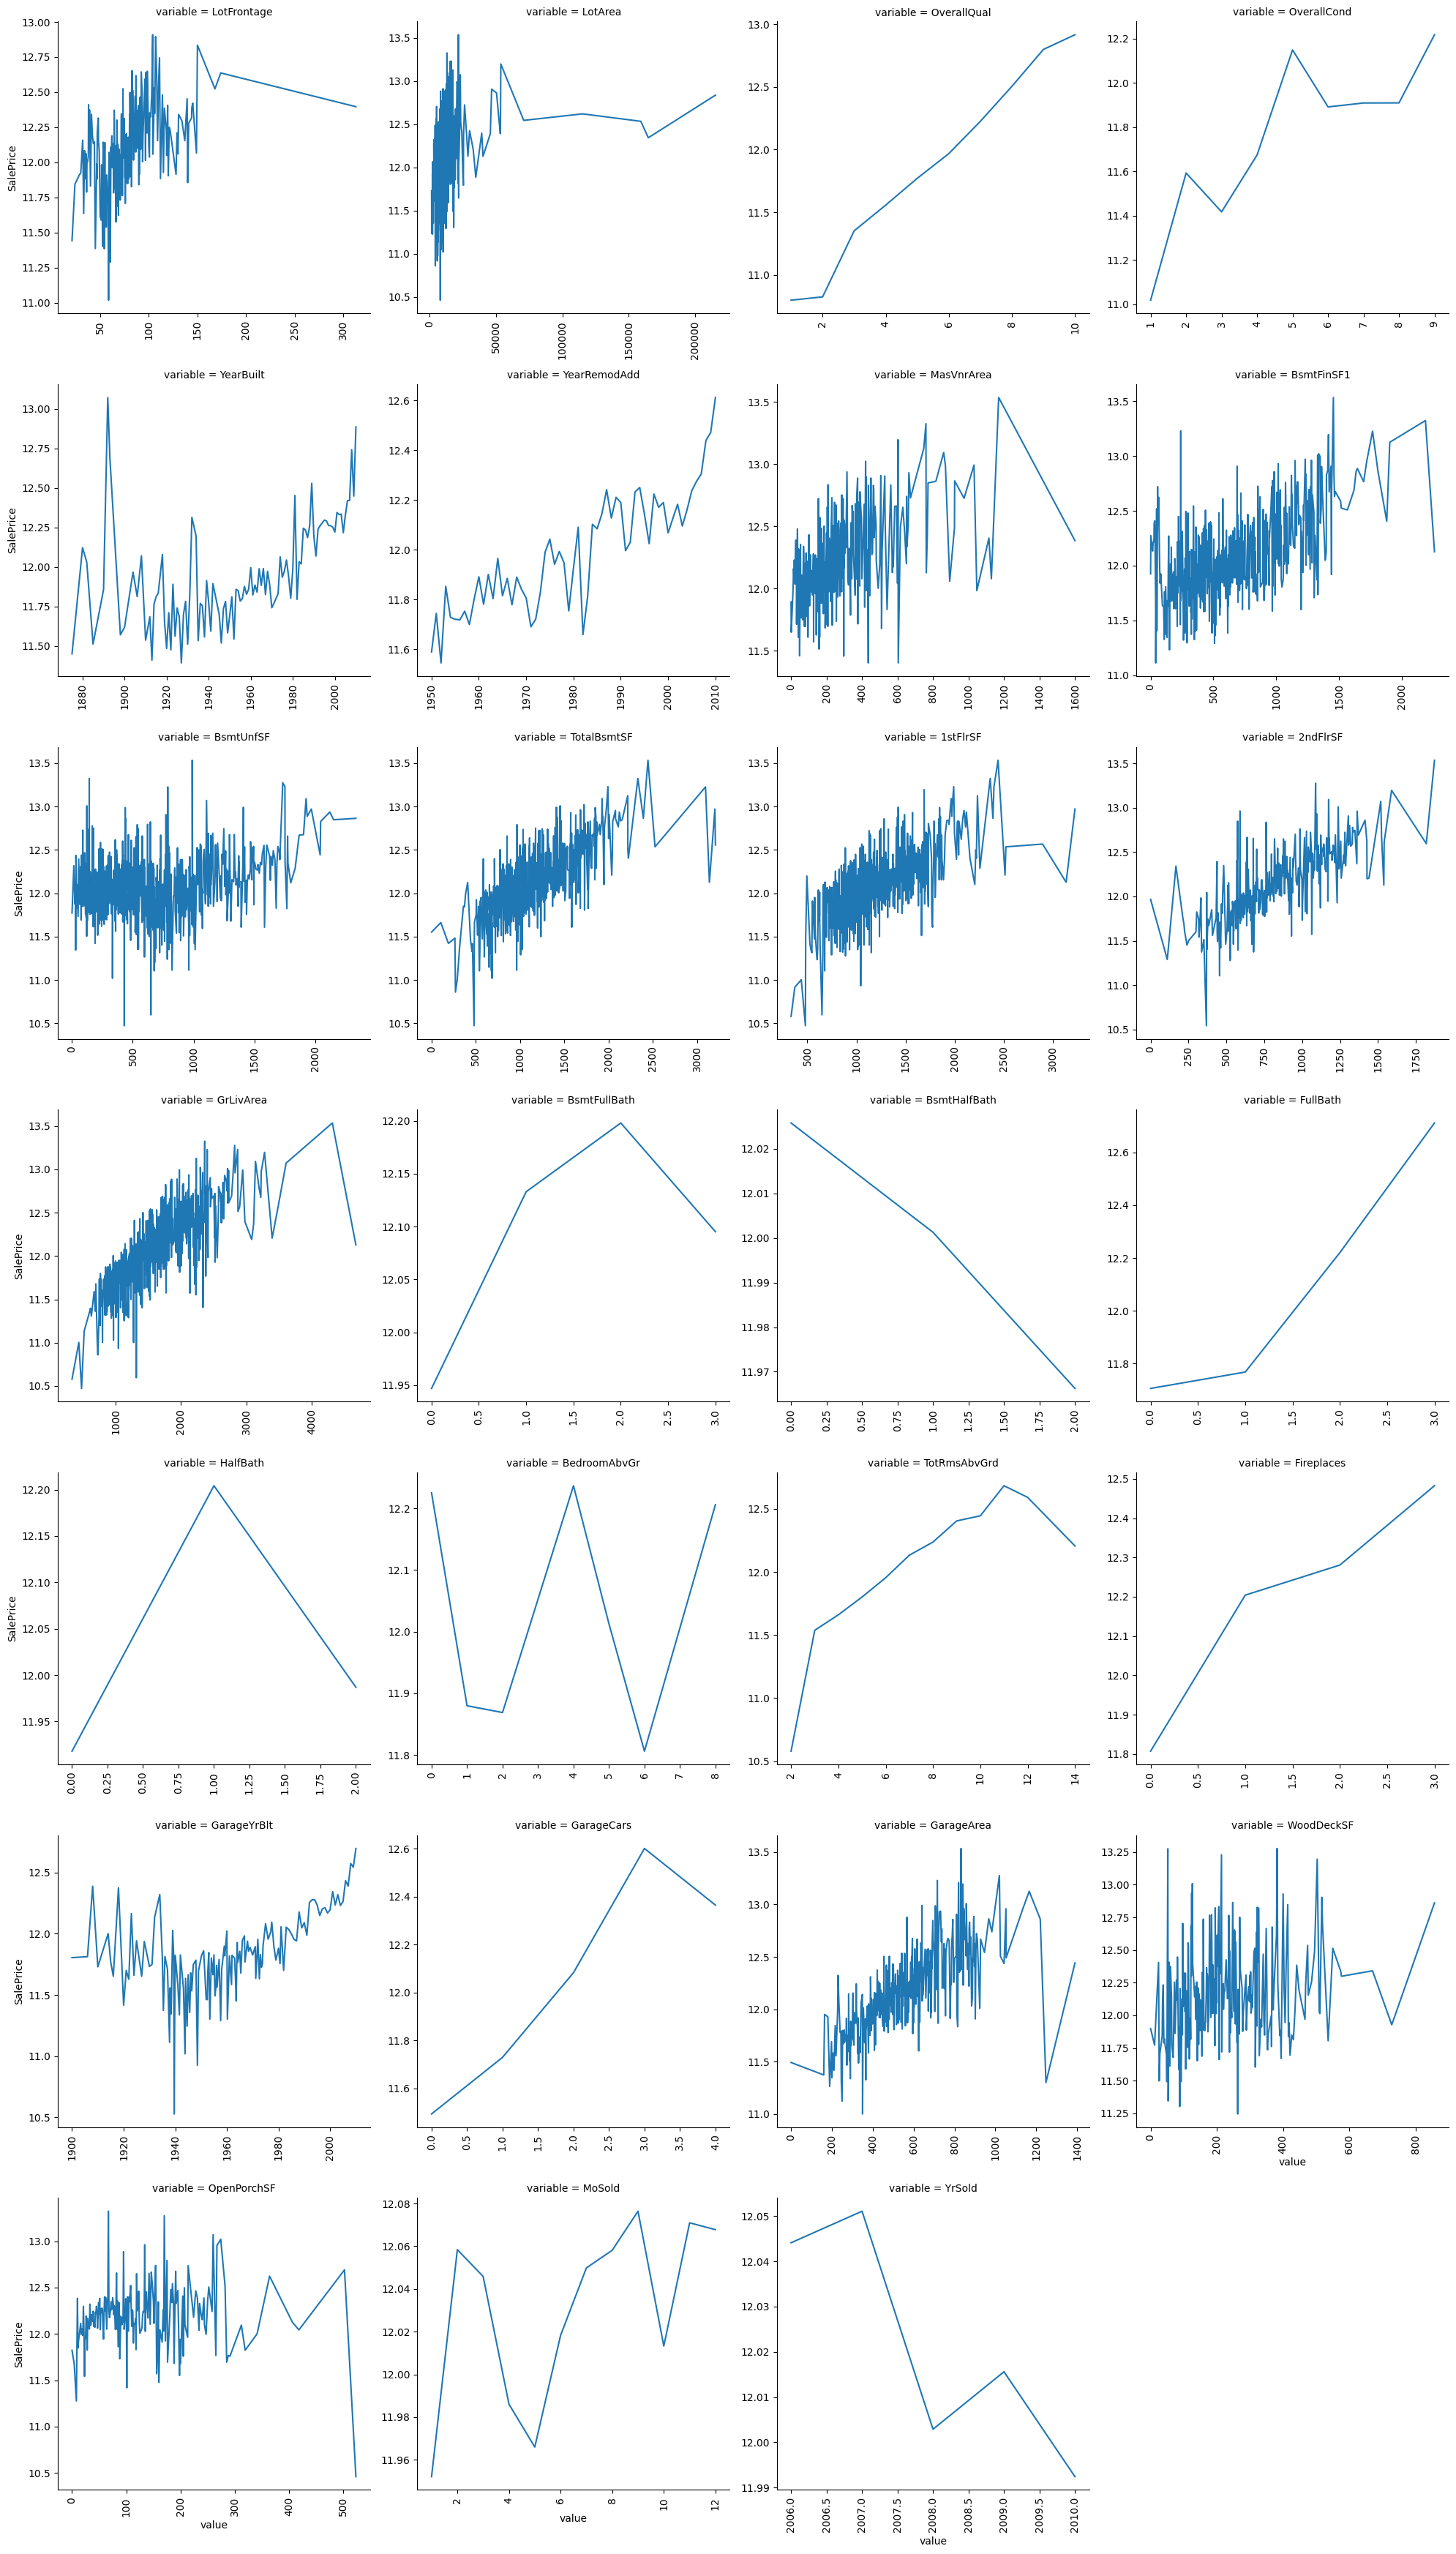

In [32]:
# 선그래프그리기
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(df_train_encoded, id_vars=['SalePrice'], value_vars=feats_n)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

RMSE of nested model with train sample: 0.01316742740617451


SalePrice(observed)  Prediction  Residual
Id                                             
1               12.247694   12.246003  0.001692
2               12.109011   12.265414 -0.156403
3               12.317167   12.254486  0.062681
4               11.849398   11.972468 -0.123070
5               12.429216   12.597521 -0.168304
...                   ...         ...       ...
1165            12.175613   12.248491 -0.072878
1166            12.359523   12.294822  0.064701
1167            12.410441   12.368005  0.042436
1168            12.061047   12.185800 -0.124753
1169            12.367341   12.260417  0.106924

[1152 rows x 3 columns]

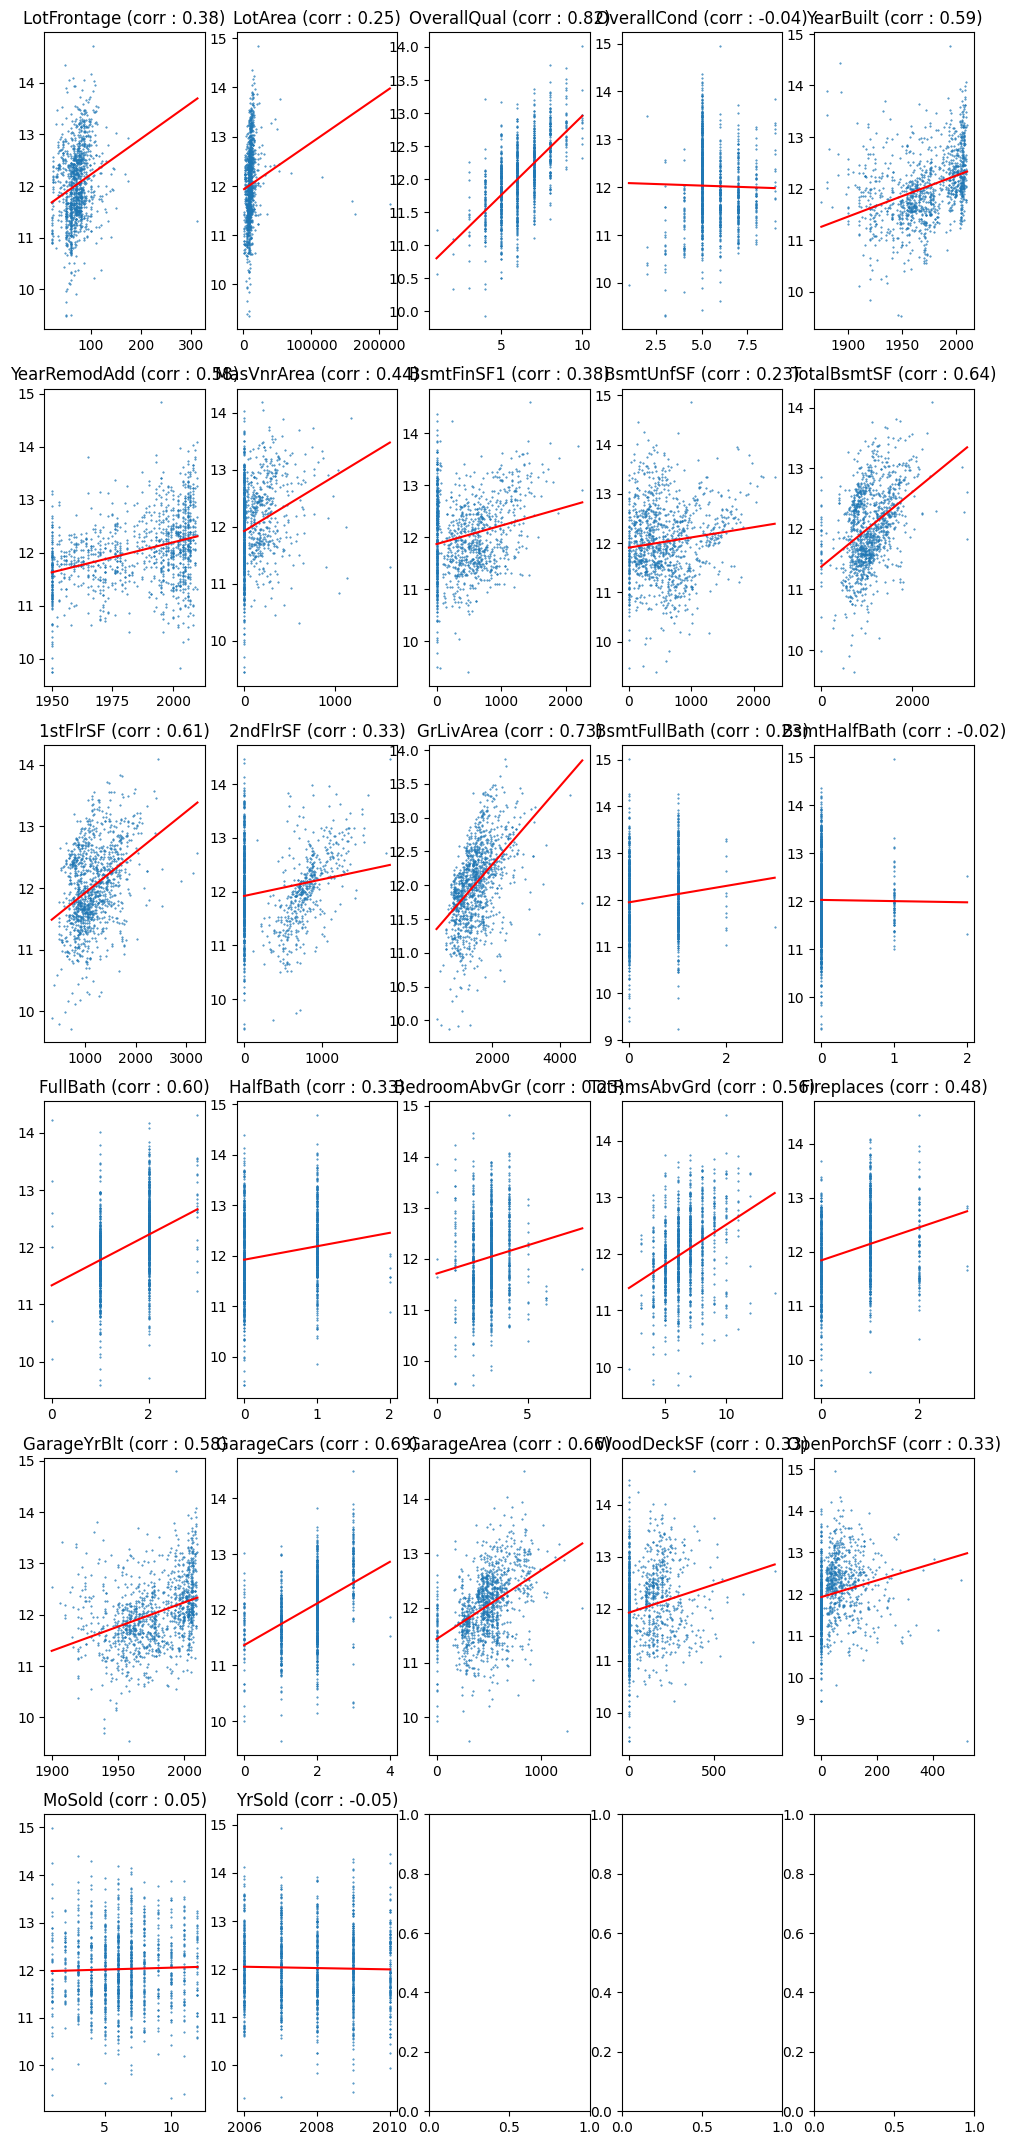

In [33]:
# 편잔차분석

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


predictor = feats
outcome = 'SalePrice'

df_train_encoded[feats] = df_train_encoded[feats].astype("float64")

lm = LinearRegression()
lm.fit(df_train_encoded[predictor], df_train_encoded[outcome])
pred = lm.predict(df_train_encoded[predictor])
resid = df_train_encoded[outcome] - pred
 


lm_nested =pd.DataFrame([df_train_encoded[outcome].values, pred, resid], 
                        index=[f"{outcome}(observed)", "Prediction", "Residual"], 
                        columns=df_train.index).T

print("RMSE of nested model with train sample:", mean_squared_error(pred, df_train_encoded[outcome]))
display(lm_nested)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
fig, axs = plt.subplots(len(feats_n)//5+1,5, figsize=(12, len(feats_n)/5*5))
resids = []
for i in range(len(feats_n)):
    # 1변량만을 이용한 회귀분석
    predictor = feats_n[i]
    outcome = 'SalePrice'

    df_train_encoded[feats_n] = df_train_encoded[feats_n].astype("float64")

    lm = LinearRegression()
    lm.fit(df_train_encoded[[predictor]], df_train_encoded[outcome])
    pred = lm.predict(df_train_encoded[[predictor]])

    resid = df_train_encoded[outcome] - pred
    
    # 회귀식 원형 + 편잔차
    partial_analysis = lm_nested["Prediction"]+resid
    
    # 시각화
    x=np.linspace(df_train_encoded[predictor].min(), df_train_encoded[predictor].max())
    y = lm.coef_[0]*x + lm.intercept_
    
    r = i // 5
    c = i % 5

    axs[r,c].plot(x,y, c='r')
    axs[r,c].scatter(df_train_encoded[predictor].values,partial_analysis,s=0.2)
    axs[r,c].set_title("{} (corr : {:.2f})".format(predictor, df_train_encoded[feats_n+["SalePrice"]].corr()["SalePrice"][i]))
plt.show()


## 2-3) Categorical 변수 확인 (X~X)

- 상관계수 확인

1. 독립변수간에 선형상관성을 가질 경우 다중공선성의 문제를 야기할 수 있습니다.

대상 :  ['GarageCond:GarageArea',
        'GarageQual:GarageArea']

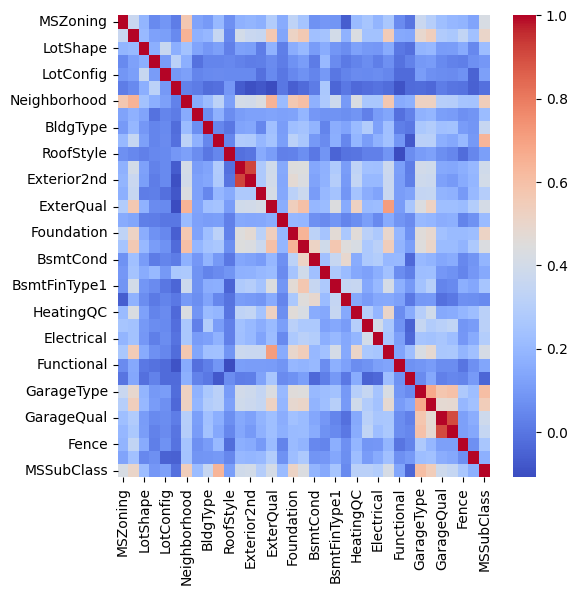

In [34]:
# 상관계수 분석
corr_c = df_train_encoded[feats_c].corr()
plt.figure(figsize=(6,6))
f = sns.heatmap(corr_c, cmap='coolwarm')

## 2-4) Categoriccal 변수 확인 (y~X)

1. unownded는 하나의 변수로 포함하여 표시되어 있음
2. 일부 클래스의 경우 다른 클래스에 비해서 높은 변동성을 보이는 경우도 있음.
3. 가장 많은 클래스를 가진 변수의 클래스 갯수는 25개임. (Neighborhood) : 유사한 성질을 가지는 카테고리끼리 통폐합하여도 됨.
    - 카테고리 변수의 경우 클래스 구분이 충분하지 않은 경우 smoothing이 부족하여 선 그래프로 유의미한 결과를 획득하기 어렵다.
    - 편잔차분석에 따르면, 일관적인 잔차의 움직임을 확인할 수는 없었습니다.
4. 이상치를 클래스별로 더러 가지고 있는 것으로 확인됨

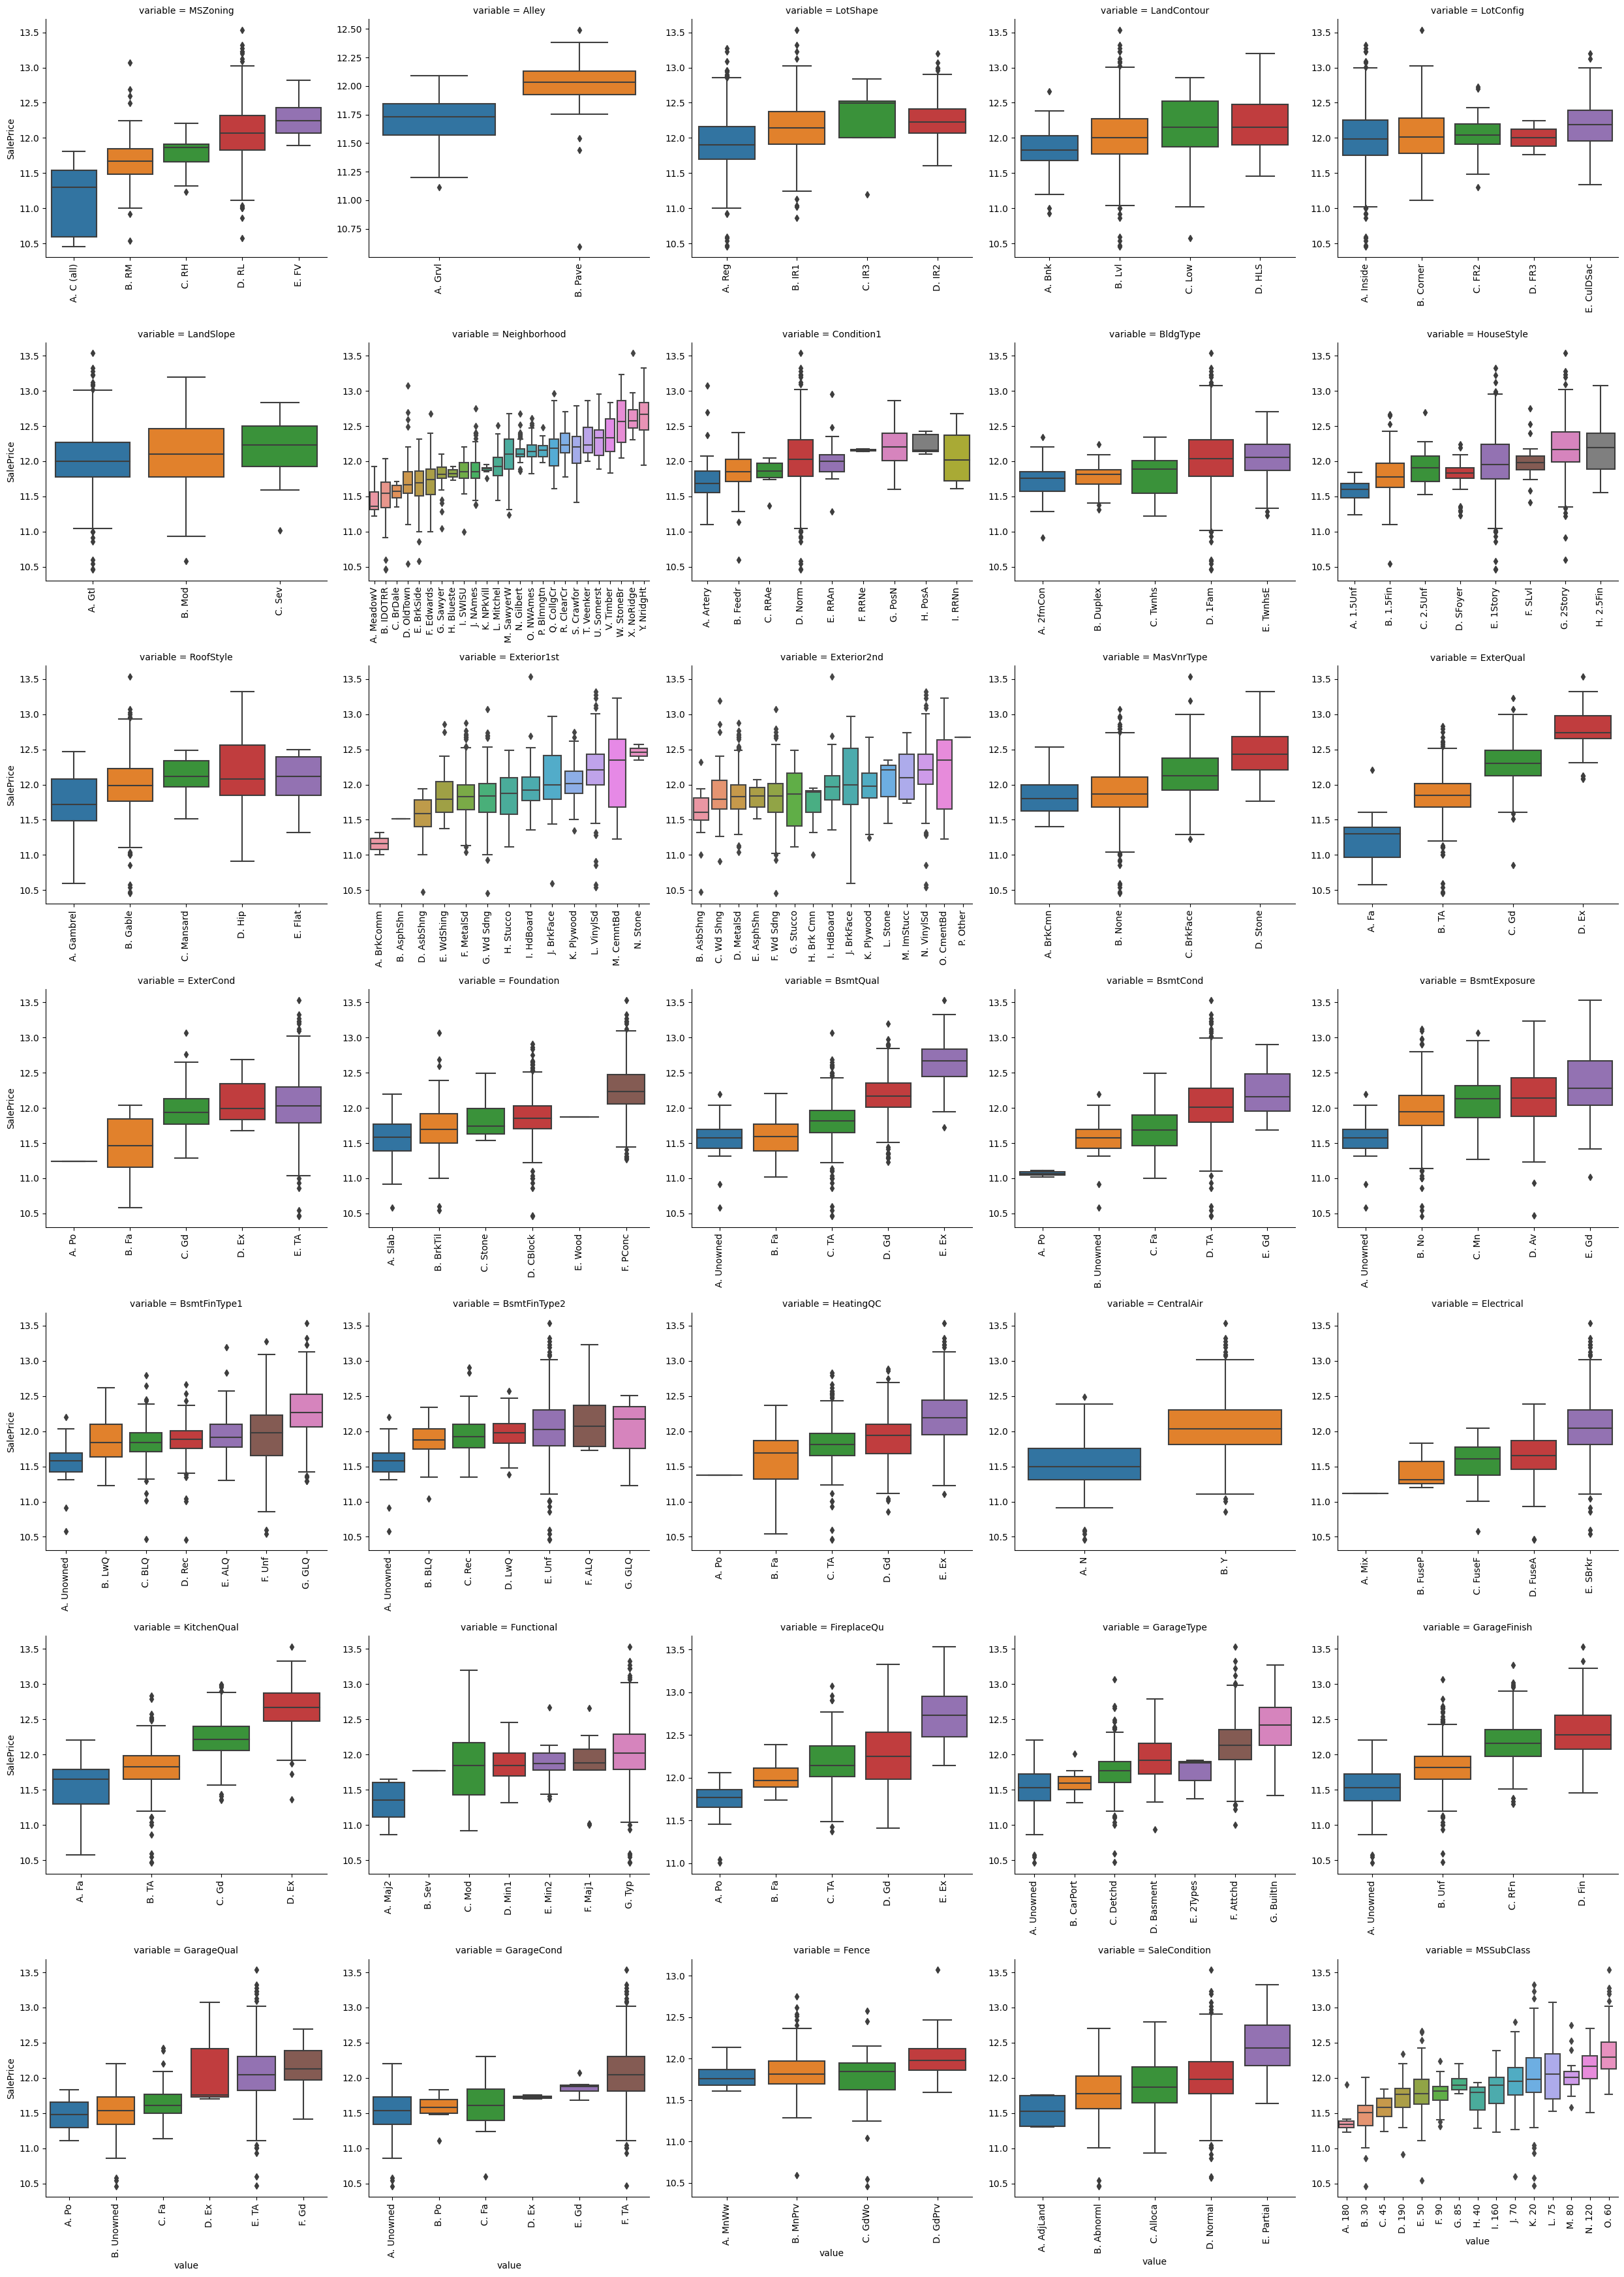

In [35]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
# 데이터 재정렬
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=feats_c)

# 오름순으로 그래프 표시하기 위한 정렬 (평균보다 robust한 mean 값을 이용)
for i in feats_c :    
    f.iloc[f[f["variable"]==i].index,:]=f[f["variable"]==i].sort_values("value")    

# 그래프 그리기
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice", )

RMSE of nested model with train sample: 0.01316742740617451


SalePrice(observed)  Prediction  Residual
Id                                             
1               12.247694   12.246003  0.001692
2               12.109011   12.265414 -0.156403
3               12.317167   12.254486  0.062681
4               11.849398   11.972468 -0.123070
5               12.429216   12.597521 -0.168304
...                   ...         ...       ...
1165            12.175613   12.248491 -0.072878
1166            12.359523   12.294822  0.064701
1167            12.410441   12.368005  0.042436
1168            12.061047   12.185800 -0.124753
1169            12.367341   12.260417  0.106924

[1152 rows x 3 columns]

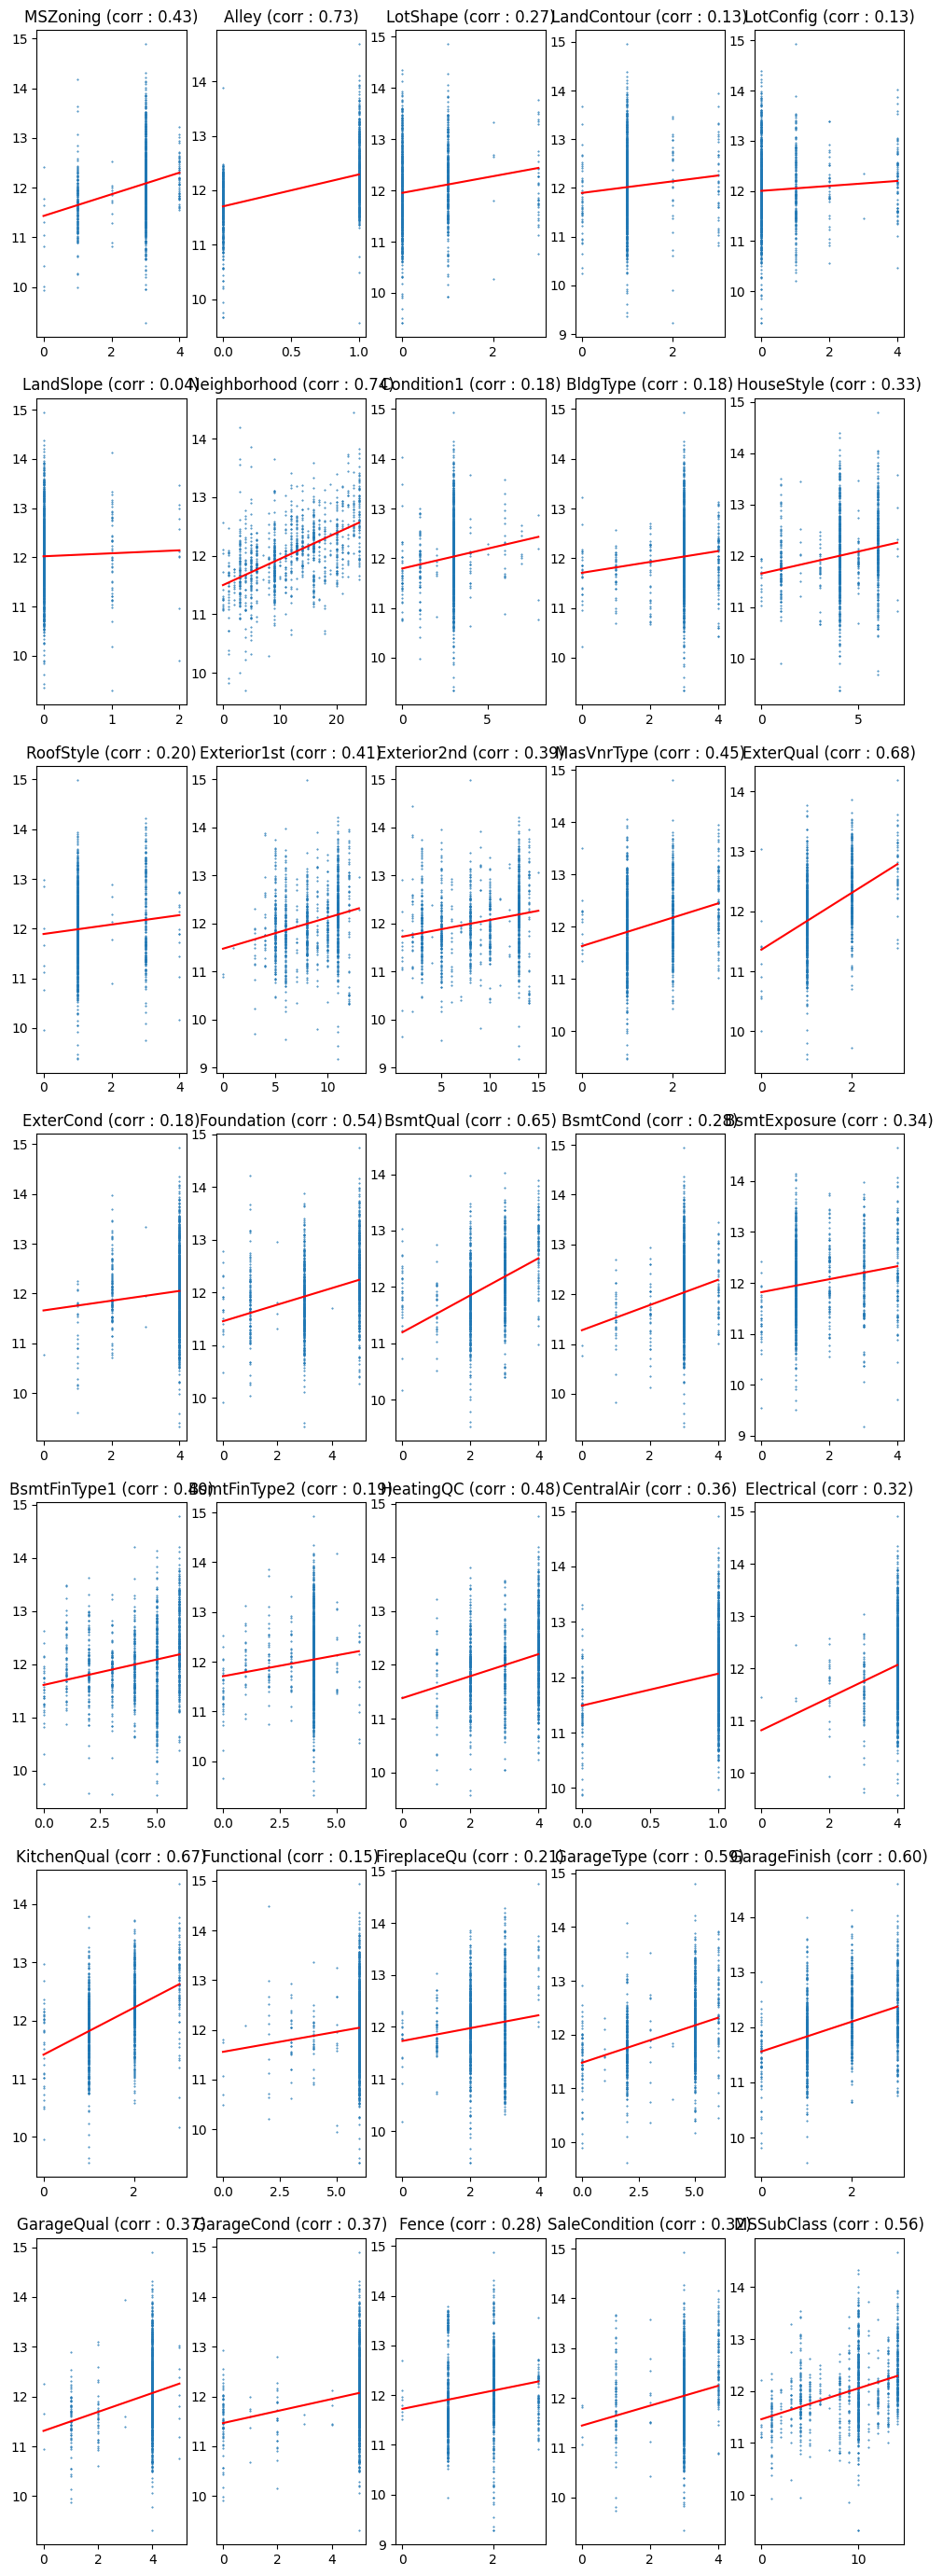

In [36]:
# 편잔차분석

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


predictor = feats
outcome = 'SalePrice'

df_train_encoded[feats] = df_train_encoded[feats].astype("float64")

lm = LinearRegression()
lm.fit(df_train_encoded[predictor], df_train_encoded[outcome])
pred = lm.predict(df_train_encoded[predictor])
resid = df_train_encoded[outcome] - pred
 


lm_nested =pd.DataFrame([df_train_encoded[outcome].values, pred, resid], 
                        index=[f"{outcome}(observed)", "Prediction", "Residual"], 
                        columns=df_train.index).T

print("RMSE of nested model with train sample:", mean_squared_error(pred, df_train_encoded[outcome]))
display(lm_nested)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
fig, axs = plt.subplots(len(feats_c)//5,5, figsize=(12, len(feats_c)/5*5))
resids = []
for i in range(len(feats_c)):
    # 1변량만을 이용한 회귀분석
    predictor = feats_c[i]
    outcome = 'SalePrice'

    df_train_encoded[feats_c] = df_train_encoded[feats_c].astype("float64")

    lm = LinearRegression()
    lm.fit(df_train_encoded[[predictor]], df_train_encoded[outcome])
    pred = lm.predict(df_train_encoded[[predictor]])

    resid = df_train_encoded[outcome] - pred
    
    # 회귀식 원형 + 편잔차
    partial_analysis = lm_nested["Prediction"]+resid
    
    # 시각화
    x=np.linspace(df_train_encoded[predictor].min(), df_train_encoded[predictor].max())
    y = lm.coef_[0]*x + lm.intercept_
    
    r = i // 5
    c = i % 5

    axs[r,c].plot(x,y, c='r')
    axs[r,c].scatter(df_train_encoded[predictor].values,partial_analysis,s=0.2)
    axs[r,c].set_title("{} (corr : {:.2f})".format(predictor, df_train_encoded[feats_c+["SalePrice"]].corr()["SalePrice"][i]))
plt.show()


2-5) Numerical 변수 vs Categorical 변수 (X~X)

<Axes: >

<Figure size 800x800 with 0 Axes>

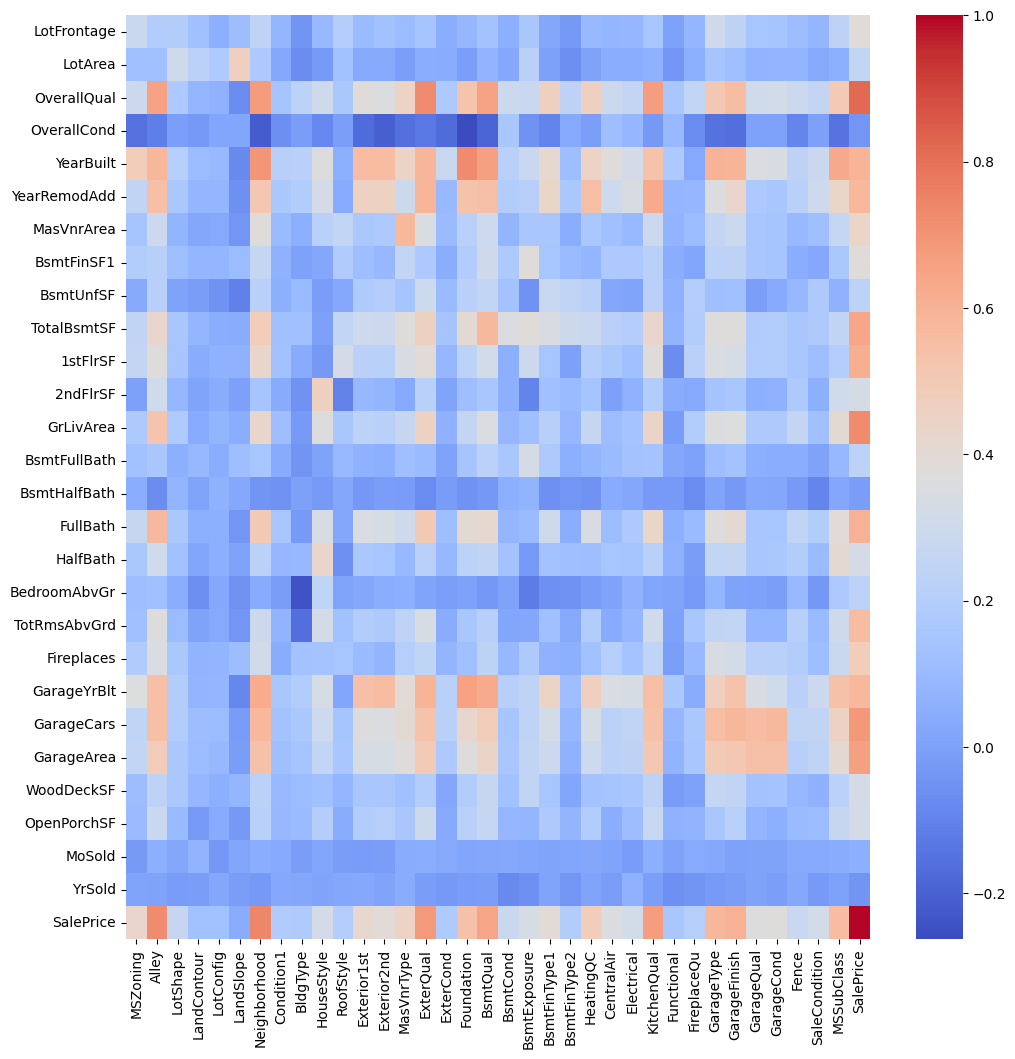

In [37]:
# 상관계수 확인
cmap='coolwarm'


plt.figure(3, figsize=(8,8))

corr = pd.DataFrame(np.zeros([len(feats_n)+1, len(feats_c)+1]), index=feats_n+['SalePrice'], columns=feats_c+['SalePrice'])
for q1 in feats_n+['SalePrice']:
    for q2 in feats_c+['SalePrice']:
        corr.loc[q1, q2] = df_train_encoded[q1].corr(df_train_encoded[q2])

plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap=cmap)

#### 4단계 : 자료가공(wrangling)과 데이터준비(preparation)

- 특성공학 : 스케일링과 스트럭쳐링

EDA 과정을 통해 파악한 내용을 변수들에게 적용한다. 
1. 히스토그램을 통해 파악한 분포의 우측치우침 현상을 log 스케일링을 통해 정규분포화 한다.
2. pairplot 및 편잔차분석을 통해 확인한 비선형관계를 quadratic 및 스플라인을 통해서 적합화한다.
3. 상관계수분석을 통해 파악한 독립변수간 상호작용을 상호작용항을 통해서 적합화한다.
4. 수치형 변수에서 '0' 값이 많이 관측되었던 사실로 미루어, \
보유여부 자체가 중요하다고 생각되는 항목들에 대해서 보유여부를 나타내는 이진변수를 생성한다.

In [38]:
# 처리7 : 로그스케일링
log_obj = ['GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','LotFrontage','GarageArea', 'BsmtUnfSF', 'TotalBsmtSF']
def scaling_log(df, log_obj) :  
    df = df.copy() 
    for i in log_obj :
        if any(x<=0 for x in df[i].values) :
            df[i] += df[i].min() +1
        df[i] = np.log(df[i])
    return df


           
# 처리8 : quadratic
def quadratic(df) :
    df = df.copy()
    for i in qdr_obj :
        df[f"{i}2"] = df[i]**2
    return df

qdr_obj = ['YearBuilt', 'YearRemodAdd', 'GrLivArea']
qdr_res = [f"{i}2" for i in qdr_obj]



# 상호작용
corr_obj = ['ExterQual:OverallQual',             
            '1stFlrSF:2ndFlrSF', 
          'OverallQual:YearBuilt', 
          'BldgType:KitchenAbvGr', 
          'YearBuilt:GarageYrBlt', 
          'GarageCond:GarageArea',
          'GarageQual:GarageArea']


# 5단계 : 모델 선택 

1. 모델의 갯수 설정
2. 선형모델
	- 단계적 회귀분석(전진선택)
	- 잔차분석 : 비정상성 진단과 처리
3. 비선형모델	
	- 상호관계항
	- 다항회귀 
	- 잔차분석 : 비정상성 진단과 처리
4. 기계학습
	- 비지도학습 : 의사결정나무, KNN
	- 인공신경망모형 : DNN
	- 지도학습 : 랜덤포레스트
5. 모델튜닝(기계학습 모형 채택 경우)

<Figure size 640x480 with 0 Axes>

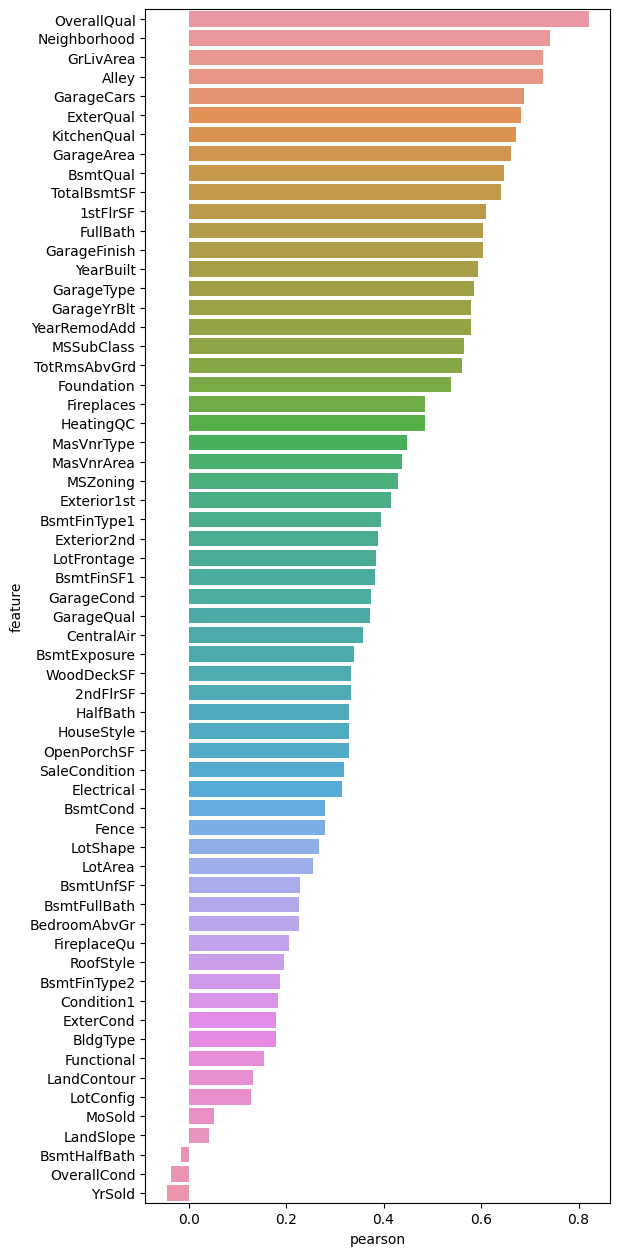

In [39]:
# 상관계수 정렬   
def pearson(frame, features, display=False):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['pearson'] = [frame[f].corr(frame['SalePrice'], 'pearson') for f in features]
    spr = spr.sort_values('pearson', ascending=False)
    if display :
        plt.figure(figsize=(6, 0.25*len(features)))
        sns.barplot(data=spr, y='feature', x='pearson', orient='h')

    return spr


    

plt.figure()
df_corr=pearson(df_train_encoded, feats, display=True)
plt.show()

model                                            feature      RMSE  \
0    stepwise1                                      [OverallQual]  0.052409   
1    stepwise2                        [OverallQual, Neighborhood]  0.042018   
2    stepwise3             [OverallQual, Neighborhood, GrLivArea]  0.029253   
3    stepwise4      [OverallQual, Neighborhood, GrLivArea, Alley]  0.027385   
4    stepwise5  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.025778   
..         ...                                                ...       ...   
56  stepwise57  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.013958   
57  stepwise58  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.013937   
58  stepwise59  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.013937   
59  stepwise60  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.013933   
60  stepwise61  [OverallQual, Neighborhood, GrLivArea, Alley, ...  0.013224   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
0   0.675739           0.675457  1.663966e-283  -123.647361  -113.548851   
1   0.740028           0.739575   0.000000e+00  -376.209844  -361.062080   
2   0.819006           0.818533   0.000000e+00  -791.361499  -771.164480   
3   0.830562           0.829972   0.000000e+00  -865.370454  -840.124180   
4   0.840510           0.839814   0.000000e+00  -933.067878  -902.772349   
..       ...                ...            ...          ...          ...   
56  0.913637           0.909137   0.000000e+00 -1535.733504 -1242.876724   
57  0.913768           0.909192   0.000000e+00 -1535.476276 -1237.570240   
58  0.913768           0.909109   0.000000e+00 -1533.476295 -1230.521005   
59  0.913795           0.909054   0.000000e+00 -1531.845462 -1223.840917   
60  0.918179           0.913600   0.000000e+00 -1589.962637 -1276.908837   

     RMSE_CV  
0   0.052520  
1   0.041110  
2   0.036740  
3   0.031824  
4   0.028505  
..       ...  
56  0.033821  
57  0.033941  
58  0.033940  
59  0.033861  
60  0.032496  

[61 rows x 9 columns]

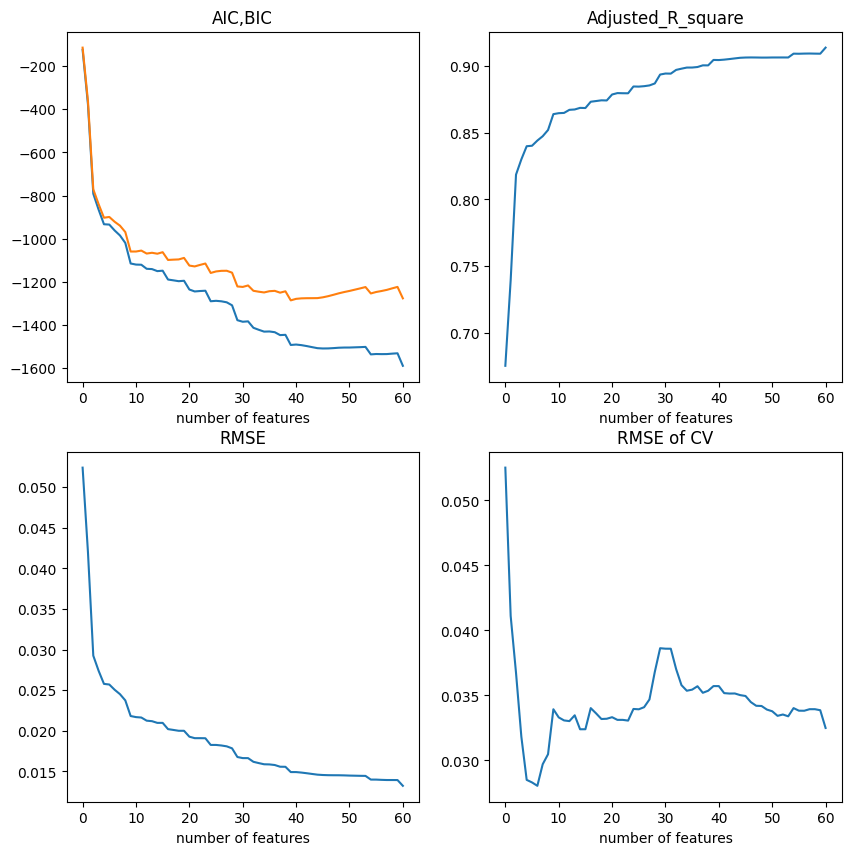

In [40]:
from statsmodels.api import OLS

def stepwise_regression(df_train, df_cv, feature) :

    df_train = df_train.copy()
    df_cv = df_cv.copy()
    
    df_corr = pearson(df_train,feature)

    stepwise_predictor = [df_corr['feature'].values[:i] for i in range(1,len(feats))]
    res_RMSE = []
    res_RMSE_CV = []
    res_R_square = []
    res_Adjusted_R_square = []
    res_F_stastic = []
    res_AIC = []
    res_BIC = []
    res_CV_prediction = []

    
    until = len(stepwise_predictor)

    for i in stepwise_predictor[:until] :
        predictor = i
        outcome = "SalePrice"

        #X = sm.add_constant(df_train[predictor])
        X = df_train[predictor]
        X = sm.add_constant(X)
        y = df_train[outcome]

        model = OLS(y,X)
        result = model.fit()
        prediction =  result.predict(X)      
        
        
        #df_cv.insert(0,'const', [result.params[0] for _ in range(len(df_cv))])
        X_CV = df_cv[predictor]
        X_CV = sm.add_constant(X_CV)
        prediction_CV = result.predict(X_CV)

        

        
        res_RMSE.append(mean_squared_error(y, prediction))
        res_RMSE_CV.append(mean_squared_error(df_cv[outcome], prediction_CV))
        res_R_square.append(result.rsquared)
        res_Adjusted_R_square.append(result.rsquared_adj)
        res_F_stastic.append(result.f_pvalue)
        res_AIC.append(result.aic)
        res_BIC.append(result.bic)

            # 단계적 선형회귀
    agg = pd.DataFrame()
    agg["model"] = [f"stepwise{i+1}" for i in range((until))]
    agg["feature"] = stepwise_predictor
    agg["RMSE"] = res_RMSE
    agg["R_square"] = res_R_square
    agg["Adjusted_R_square"] = res_Adjusted_R_square
    agg["F_stastic"] = res_F_stastic
    agg["AIC"] = res_AIC
    agg["BIC"] = res_BIC
    agg["RMSE_CV"] = res_RMSE_CV


    if display :
        display(agg)

        fig, axs = plt.subplots(2,2, figsize = (10,10))
        axs[0,0].plot(agg[['AIC','BIC']])
        axs[0,0].set_xlabel('number of features')
        axs[0,0].set_title('AIC,BIC')
        axs[0,1].plot(agg[['Adjusted_R_square']])
        axs[0,1].set_xlabel('number of features')
        axs[0,1].set_title('Adjusted_R_square')
        axs[1,0].plot(agg[['RMSE']])
        axs[1,0].set_xlabel('number of features')
        axs[1,0].set_title('RMSE')
        axs[1,1].plot(agg[['RMSE_CV']])
        axs[1,1].set_xlabel('number of features')
        axs[1,1].set_title('RMSE of CV')
        plt.show()

    return agg


linear_regression_original = stepwise_regression(df_train_encoded, df_cv_encoded, feats)


model                                            feature      RMSE  \
0    stepwise1                                      [OverallQual]  0.052409   
1    stepwise2                           [OverallQual, GrLivArea]  0.038082   
2    stepwise3             [OverallQual, GrLivArea, Neighborhood]  0.028782   
3    stepwise4      [OverallQual, GrLivArea, Neighborhood, Alley]  0.027372   
4    stepwise5  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.025783   
..         ...                                                ...       ...   
56  stepwise57  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.013628   
57  stepwise58  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.013596   
58  stepwise59  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.013596   
59  stepwise60  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.013582   
60  stepwise61  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.012751   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
0   0.675739           0.675457  1.663966e-283  -123.647361  -113.548851   
1   0.764383           0.763973   0.000000e+00  -489.529897  -474.382133   
2   0.821923           0.821458   0.000000e+00  -810.082586  -789.885567   
3   0.830644           0.830053   0.000000e+00  -865.923468  -840.677194   
4   0.840475           0.839779   0.000000e+00  -932.816508  -902.520979   
..       ...                ...            ...          ...          ...   
56  0.915684           0.911291   0.000000e+00 -1563.362414 -1270.505633   
57  0.915879           0.911416   0.000000e+00 -1564.040342 -1266.134306   
58  0.915880           0.911335   0.000000e+00 -1562.044686 -1259.089396   
59  0.915965           0.911344   0.000000e+00 -1561.215314 -1253.210768   
60  0.921106           0.916691   0.000000e+00 -1631.938488 -1318.884688   

     RMSE_CV  
0   0.052520  
1   0.043467  
2   0.032599  
3   0.029215  
4   0.026542  
..       ...  
56  0.024353  
57  0.024519  
58  0.024510  
59  0.024452  
60  0.022281  

[61 rows x 9 columns]

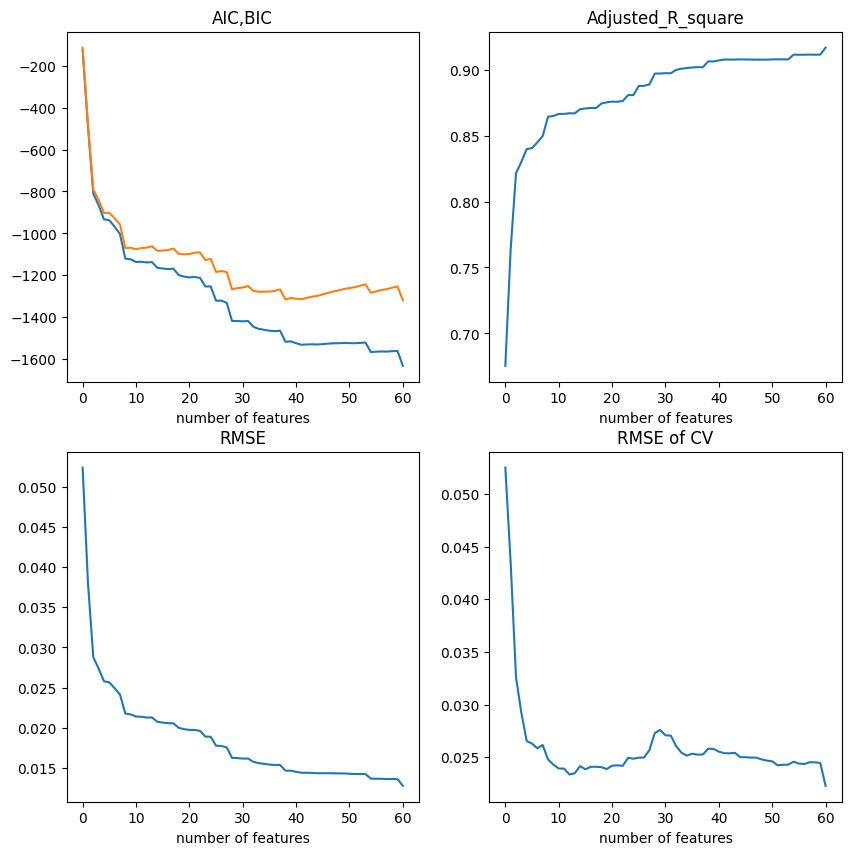

In [41]:
# 로그변환
df_train_encoded_log = scaling_log(df_train_encoded, log_obj)
df_cv_encoded_log = scaling_log(df_cv_encoded, log_obj)

linear_regression_log = stepwise_regression(df_train_encoded_log, df_cv_encoded_log, feats)

In [42]:
linear_regression_log.sort_values("RMSE_CV")

model                                            feature      RMSE  \
60  stepwise61  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.012751   
12  stepwise13  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.021267   
13  stepwise14  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.021261   
15  stepwise16  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.020628   
19  stepwise20  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.019816   
..         ...                                                ...       ...   
29  stepwise30  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.016205   
3    stepwise4      [OverallQual, GrLivArea, Neighborhood, Alley]  0.027372   
2    stepwise3             [OverallQual, GrLivArea, Neighborhood]  0.028782   
1    stepwise2                           [OverallQual, GrLivArea]  0.038082   
0    stepwise1                                      [OverallQual]  0.052409   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
60  0.921106           0.916691   0.000000e+00 -1631.938488 -1318.884688   
12  0.868419           0.866916   0.000000e+00 -1138.665213 -1067.975645   
13  0.868455           0.866835   0.000000e+00 -1136.982785 -1061.243962   
15  0.872369           0.870570   0.000000e+00 -1167.778170 -1081.940838   
19  0.877397           0.875229   0.000000e+00 -1206.084741 -1100.050389   
..       ...                ...            ...          ...          ...   
29  0.899738           0.897054   0.000000e+00 -1417.818451 -1261.291551   
3   0.830644           0.830053   0.000000e+00  -865.923468  -840.677194   
2   0.821923           0.821458   0.000000e+00  -810.082586  -789.885567   
1   0.764383           0.763973   0.000000e+00  -489.529897  -474.382133   
0   0.675739           0.675457  1.663966e-283  -123.647361  -113.548851   

     RMSE_CV  
60  0.022281  
12  0.023360  
13  0.023471  
15  0.023855  
19  0.023874  
..       ...  
29  0.027587  
3   0.029215  
2   0.032599  
1   0.043467  
0   0.052520  

[61 rows x 9 columns]

model                                            feature      RMSE  \
0    stepwise1                                      [OverallQual]  0.324261   
1    stepwise2                           [OverallQual, GrLivArea]  0.235617   
2    stepwise3             [OverallQual, GrLivArea, Neighborhood]  0.178077   
3    stepwise4      [OverallQual, GrLivArea, Neighborhood, Alley]  0.169356   
4    stepwise5  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.159525   
..         ...                                                ...       ...   
56  stepwise57  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084316   
57  stepwise58  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084121   
58  stepwise59  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084120   
59  stepwise60  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084035   
60  stepwise61  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.078894   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
0   0.675739           0.675457  1.663966e-283  1975.845633  1985.944143   
1   0.764383           0.763973   0.000000e+00  1609.963097  1625.110861   
2   0.821923           0.821458   0.000000e+00  1289.410408  1309.607427   
3   0.830644           0.830053   0.000000e+00  1233.569526  1258.815800   
4   0.840475           0.839779   0.000000e+00  1166.676486  1196.972015   
..       ...                ...            ...          ...          ...   
56  0.915684           0.911291   0.000000e+00   536.130580   828.987361   
57  0.915879           0.911416   0.000000e+00   535.452652   833.358688   
58  0.915880           0.911335   0.000000e+00   537.448308   840.403598   
59  0.915965           0.911344   0.000000e+00   538.277680   846.282226   
60  0.921106           0.916691   0.000000e+00   467.554506   780.608306   

     RMSE_CV  
0   0.339212  
1   0.278571  
2   0.208656  
3   0.187875  
4   0.171334  
..       ...  
56  0.151700  
57  0.152642  
58  0.152591  
59  0.152282  
60  0.138424  

[61 rows x 9 columns]

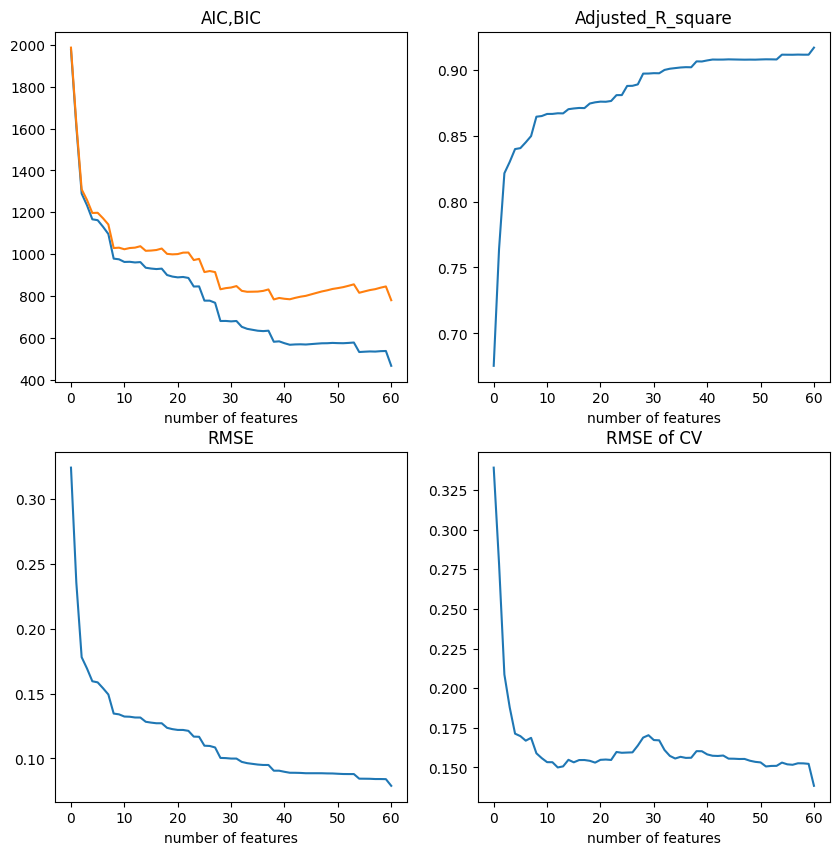

In [43]:
# 표준화. standardscaler

def standardize(df) :
    df = df.copy()

    scaler = StandardScaler()
    df_standardized = pd.DataFrame(scaler.fit_transform(df))
    df_standardized.index = df.index
    df_standardized.columns = df.columns
    return df_standardized

df_train_encoded_log_scaled = standardize(df_train_encoded_log)
df_cv_encoded_log_scaled = standardize(df_cv_encoded_log)
linear_regression_log_scaled = stepwise_regression(df_train_encoded_log_scaled, df_cv_encoded_log_scaled, feats) 

# 스케일 조정
s = df_train_encoded_log["SalePrice"].std()
linear_regression_log_scaled["RMSE"] = linear_regression_log_scaled["RMSE"] * s
linear_regression_log_scaled["RMSE_CV"] = linear_regression_log_scaled["RMSE_CV"] * s

model                                            feature      RMSE  \
0    stepwise1                                      [OverallQual]  0.324261   
1    stepwise2                           [OverallQual, GrLivArea]  0.235617   
2    stepwise3             [OverallQual, GrLivArea, Neighborhood]  0.178077   
3    stepwise4      [OverallQual, GrLivArea, Neighborhood, Alley]  0.169356   
4    stepwise5  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.159525   
..         ...                                                ...       ...   
56  stepwise57  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084316   
57  stepwise58  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084121   
58  stepwise59  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084120   
59  stepwise60  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.084035   
60  stepwise61  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.083715   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
0   0.675739           0.675457  1.663966e-283  1975.845633  1985.944143   
1   0.764383           0.763973   0.000000e+00  1609.963097  1625.110861   
2   0.821923           0.821458   0.000000e+00  1289.410408  1309.607427   
3   0.830644           0.830053   0.000000e+00  1233.569526  1258.815800   
4   0.840475           0.839779   0.000000e+00  1166.676486  1196.972015   
..       ...                ...            ...          ...          ...   
56  0.915684           0.911291   0.000000e+00   536.130580   828.987361   
57  0.915879           0.911416   0.000000e+00   535.452652   833.358688   
58  0.915880           0.911335   0.000000e+00   537.448308   840.403598   
59  0.915965           0.911344   0.000000e+00   538.277680   846.282226   
60  0.916285           0.911600   0.000000e+00   535.892342   848.946142   

     RMSE_CV  
0   0.339212  
1   0.278571  
2   0.208656  
3   0.187875  
4   0.171334  
..       ...  
56  0.151700  
57  0.152642  
58  0.152591  
59  0.152282  
60  0.154356  

[61 rows x 9 columns]

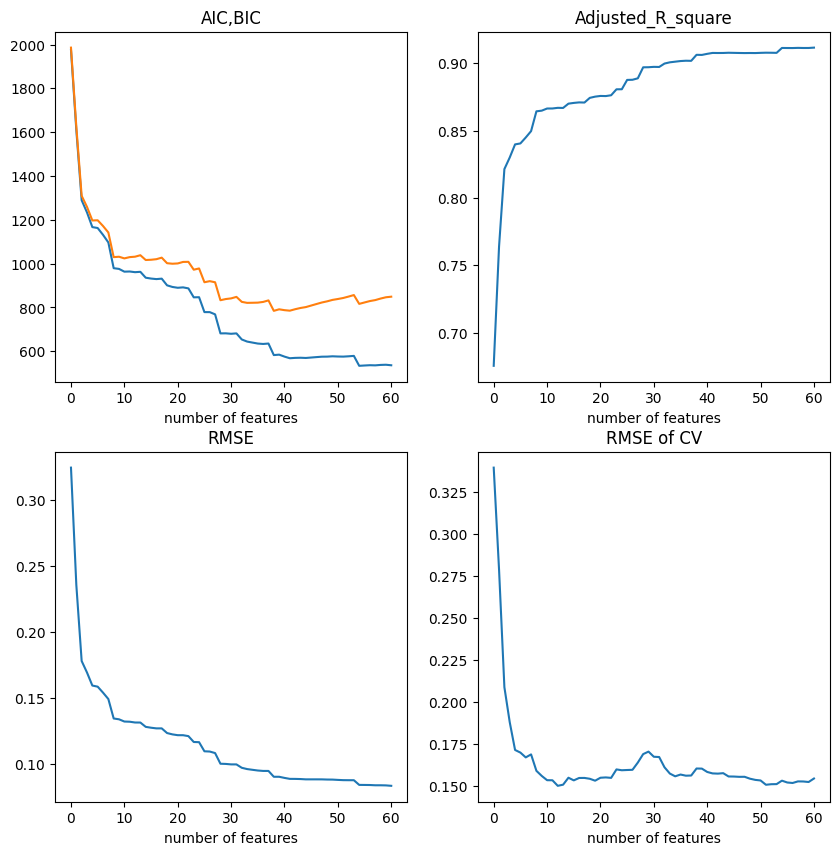

In [44]:
# poly항 추가하기

# 처리8 : quadratic
def quadratic(df, qdr_obj) :
    for i in qdr_obj :
        df[f"{i}2"] = df[i]**2
    return df

qdr_res = [f"{i}2" for i in qdr_obj]

df_train_encoded_log_scaled_quad = quadratic(df_train_encoded_log_scaled, qdr_obj)
df_cv_encoded_log_scaled_quad = quadratic(df_cv_encoded_log_scaled, qdr_obj)


linear_regression_log_scaled_quad = stepwise_regression(df_train_encoded_log_scaled_quad, df_cv_encoded_log_scaled_quad, feats+qdr_res) 

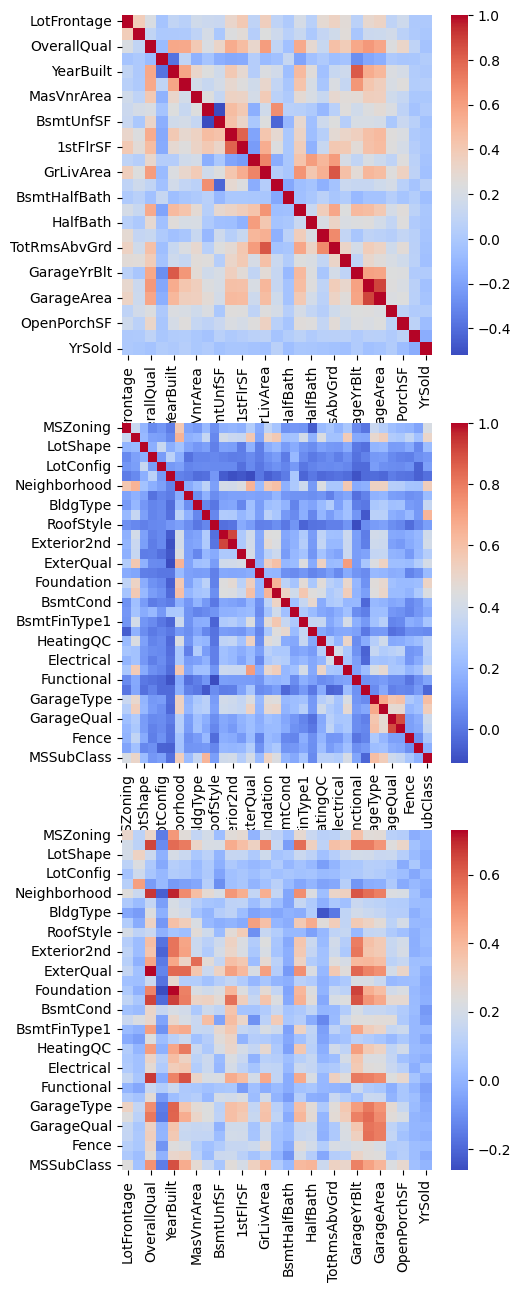

In [45]:
fig, axs = plt.subplots(3,1, figsize=(5,15))

sns.heatmap(df_train_encoded[feats_n].corr(), ax=axs[0], cmap='coolwarm')
sns.heatmap(df_train_encoded[feats_c].corr(), ax=axs[1], cmap='coolwarm')
corr_cross = df_train_encoded.corr()[feats_n].loc[feats_c,:]
sns.heatmap(corr_cross, ax=axs[2] , cmap='coolwarm')
plt.show()

model                                            feature      RMSE  \
0    stepwise1                                      [OverallQual]  0.324261   
1    stepwise2                           [OverallQual, GrLivArea]  0.235617   
2    stepwise3             [OverallQual, GrLivArea, Neighborhood]  0.178077   
3    stepwise4      [OverallQual, GrLivArea, Neighborhood, Alley]  0.169356   
4    stepwise5  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.159525   
..         ...                                                ...       ...   
56  stepwise57  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.083845   
57  stepwise58  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.083781   
58  stepwise59  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.082475   
59  stepwise60  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.082317   
60  stepwise61  [OverallQual, GrLivArea, Neighborhood, Alley, ...  0.082299   

    R_square  Adjusted_R_square      F_stastic          AIC          BIC  \
0   0.675739           0.675457  1.663966e-283  1975.845633  1985.944143   
1   0.764383           0.763973   0.000000e+00  1609.963097  1625.110861   
2   0.821923           0.821458   0.000000e+00  1289.410408  1309.607427   
3   0.830644           0.830053   0.000000e+00  1233.569526  1258.815800   
4   0.840475           0.839779   0.000000e+00  1166.676486  1196.972015   
..       ...                ...            ...          ...          ...   
56  0.916155           0.911787   0.000000e+00   529.668100   822.524881   
57  0.916219           0.911773   0.000000e+00   530.794468   828.700503   
58  0.917525           0.913068   0.000000e+00   514.701032   817.656323   
59  0.917683           0.913156   0.000000e+00   514.478771   822.483317   
60  0.917701           0.913095   0.000000e+00   516.237585   829.291385   

     RMSE_CV  
0   0.339212  
1   0.278571  
2   0.208656  
3   0.187875  
4   0.171334  
..       ...  
56  0.152853  
57  0.152566  
58  0.149991  
59  0.150787  
60  0.150444  

[61 rows x 9 columns]

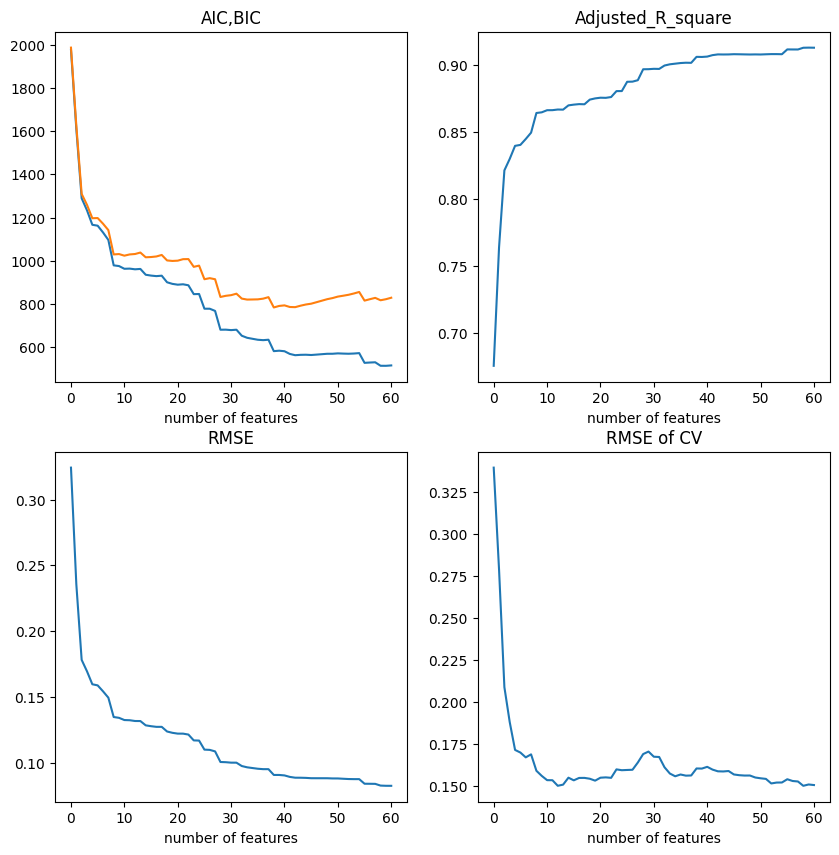

In [47]:
# 상관계수항 포함

corr_obj = ['ExterQual:OverallQual',             
            '1stFlrSF:2ndFlrSF', 
          'OverallQual:YearBuilt', 
          'YearBuilt:GarageYrBlt', 
          'GarageCond:GarageArea',
          'GarageQual:GarageArea']

def interaction(df, corr_obj) :
    df_interact = df.copy()
    for i in corr_obj :
        df[i] = np.ones(len(df))
        factors = i.split(":")        
        for j in factors :
            df[i] *= df[j]

    return df_interact

df_train_encoded_log_scaled_quad_interact = interaction(df_train_encoded_log_scaled_quad, corr_obj)
df_cv_encoded_log_scaled_quad_interact = interaction(df_cv_encoded_log_scaled_quad, corr_obj)
linear_regression_log_scaled_quad_interact = stepwise_regression(df_train_encoded_log_scaled_quad_interact, df_cv_encoded_log_scaled_quad_interact, feats+qdr_res+corr_obj) 


In [48]:
score_matrix = [linear_regression_original,linear_regression_log, linear_regression_log_scaled,linear_regression_log_scaled_quad,linear_regression_log_scaled_quad_interact]
res = pd.concat([i[i["RMSE_CV"] == i["RMSE_CV"].min()] for i in score_matrix])
score_matrix_str = ["linear_regression_original","linear_regression_log","linear_regression_log_scaled","linear_regression_log_scaled_quad","linear_regression_log_scaled_quad_interact"]
res.index = score_matrix_str
res

model  \
linear_regression_original                   stepwise7   
linear_regression_log                       stepwise61   
linear_regression_log_scaled                stepwise61   
linear_regression_log_scaled_quad           stepwise13   
linear_regression_log_scaled_quad_interact  stepwise59   

                                                                                      feature  \
linear_regression_original                  [OverallQual, Neighborhood, GrLivArea, Alley, ...   
linear_regression_log                       [OverallQual, GrLivArea, Neighborhood, Alley, ...   
linear_regression_log_scaled                [OverallQual, GrLivArea, Neighborhood, Alley, ...   
linear_regression_log_scaled_quad           [OverallQual, GrLivArea, Neighborhood, Alley, ...   
linear_regression_log_scaled_quad_interact  [OverallQual, GrLivArea, Neighborhood, Alley, ...   

                                                RMSE  R_square  \
linear_regression_original                  0.025053  0.844991   
linear_regression_log                       0.012751  0.921106   
linear_regression_log_scaled                0.031731  0.921106   
linear_regression_log_scaled_quad           0.131581  0.868419   
linear_regression_log_scaled_quad_interact  0.082475  0.917525   

                                            Adjusted_R_square  F_stastic  \
linear_regression_original                           0.844042        0.0   
linear_regression_log                                0.916691        0.0   
linear_regression_log_scaled                         0.916691        0.0   
linear_regression_log_scaled_quad                    0.866916        0.0   
linear_regression_log_scaled_quad_interact           0.913068        0.0   

                                                    AIC          BIC   RMSE_CV  
linear_regression_original                  -961.898552  -921.504513  0.028048  
linear_regression_log                      -1631.938488 -1318.884688  0.022281  
linear_regression_log_scaled                 467.554506   780.608306  0.055674  
linear_regression_log_scaled_quad            960.827781  1031.517349  0.150015  
linear_regression_log_scaled_quad_interact   514.701032   817.656323  0.149991

결과적으로는 log 모델을 선택.
- 예측능력도 가장 뛰어날 뿐 아니라
- 모델적합성을 평가하는 지표들에서도 가장 우수한 성적을 보였다.

지금까지의 분석은 고전적 회귀모델을 사용하였다.
금융데이터의 경우, 
 1. 계층적이고 잡음이 심하다는 특징을 가지고 있으며,
 2. 변수들의 상호관계가 복잡하게 얽혀있다는 특징이 있다.

고전적 회귀모형을 사용할 경우,
 1. 복잡하게 얽힌 상호관계를 확신과 함께 모델에 포함하기가 어려우며,
 2. 그렇게 하지 못할 경우 다중공선성의 문제를 겪을 수 있다.
 3. 뿐만 아니라 배치데이터세트를 활용한  선형모형은 계층구조를 충분히 반영할 수 없다는 문제가 있다.

기계학습의 힘을 빌려 해당 문제들을 해결할 수 있으며,
계층적 문제 해결에 높은 성능을 보이는 트리모형을 이용하여 해당 문제를 다루어 보고자 한다.


In [49]:
def consolidated_pipeline(df, pipeline) :
    df = df.copy()
    df = pipeline[0](df)
    df = pipeline[1](df)
    df = pipeline[2](df)
    df = pipeline[3](df)
    df = pipeline[4](df)
    df = pipeline[5](df)
    df_encoded = pipeline[6](df)
    df, df_encoded = pipeline[7](df, df_encoded)
    df, df_encoded = pipeline[8](df, df_encoded, feats)


    return df, df_encoded

df_test = pd.concat([X_test, y_test.drop("Id", axis=1)], axis=1)
df_test, df_test_encoded = consolidated_pipeline(df_test, pipeline)


In [50]:
# 최적모델 재현

linear_regression_log = linear_regression_log.sort_values("RMSE_CV")

predictor = linear_regression_log.iat[1,1]
outcome = "SalePrice"

X = df_train_encoded_log[predictor]
X = sm.add_constant(X)
y = df_train_encoded_log[outcome]

ult_model = OLS(y,X)
ult_result = ult_model.fit()
ult_prediction = ult_result.predict(X)

ult_summary = pd.DataFrame({
    'Observed' : y,
    'Predicted' : ult_prediction,
    'Residuals' : (ult_prediction - y) ** 2
})

ult_summary


Observed  Predicted  Residuals
Id                                   
1     12.247694  12.236709   0.000121
2     12.109011  12.121787   0.000163
3     12.317167  12.264928   0.002729
4     11.849398  12.172464   0.104372
5     12.429216  12.551517   0.014958
...         ...        ...        ...
1165  12.175613  12.191500   0.000252
1166  12.359523  12.379862   0.000414
1167  12.410441  12.461072   0.002564
1168  12.061047  12.125263   0.004124
1169  12.367341  12.116758   0.062792

[1152 rows x 3 columns]

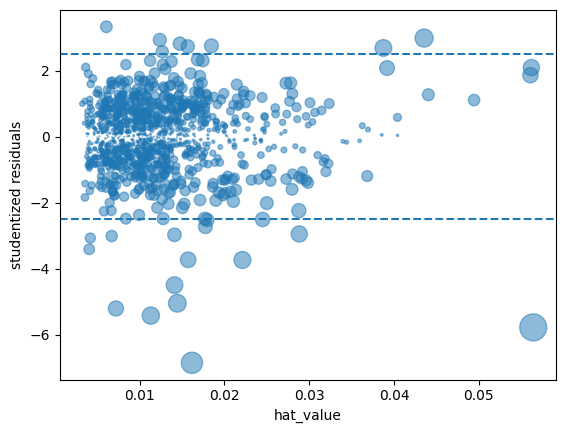

In [51]:
# 특이값, 영향값 측정

#버블 그림 시각화
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(ult_result)
plt.axhline(-2.5, linestyle = '--') # -2.5, 2.5 는 임계값
plt.axhline(2.5, linestyle = '--')
plt.scatter(influence.hat_matrix_diag, 
influence.resid_studentized_internal, 
s = 1000 * np.sqrt(influence.cooks_distance[0]),
alpha=0.5)
plt.xlabel('hat_value')
plt.ylabel('studentized residuals')
plt.show()

In [52]:
df_influencial = pd.DataFrame({
    "cooks_distance" : influence.cooks_distance[0],
    'hat_value' : influence.hat_matrix_diag
})

df_influencial = df_influencial.sort_values("cooks_distance")
df_influencial

threshold = 4 / (len(df_influencial) - len(feats))
del_obj = df_influencial[df_influencial["cooks_distance"] > threshold].index

In [53]:
# 영향값 제거 후 모델 재학습
try :
    X = X.drop(del_obj)
    y = y.drop(del_obj)
except Exception as e :
    pass

ult_model_influential = OLS(y,X)
ult_result_influential = ult_model.fit()
ult_prediction_influential = ult_result.predict(X)

ult_summary_influential = pd.DataFrame({
    'Observed' : y,
    'Predicted' : ult_prediction_influential,
    'Residuals' : (ult_prediction_influential - y) ** 2
})

ult_summary_influential


Observed  Predicted  Residuals
Id                                   
1     12.247694  12.236709   0.000121
2     12.109011  12.121787   0.000163
3     12.317167  12.264928   0.002729
5     12.429216  12.551517   0.014958
6     11.870600  11.851424   0.000368
...         ...        ...        ...
1165  12.175613  12.191500   0.000252
1166  12.359523  12.379862   0.000414
1167  12.410441  12.461072   0.002564
1168  12.061047  12.125263   0.004124
1169  12.367341  12.116758   0.062792

[1092 rows x 3 columns]

In [54]:
# 테스트 샘플에 적용

# 특이값 제거 전
X = df_test_encoded[predictor]
X = sm.add_constant(X)
y = df_test_encoded[outcome]


prediction = ult_result.predict(X)
error = mean_squared_error(prediction, y)
error

577245.3392994421

In [55]:
X = df_test_encoded[predictor]
X = sm.add_constant(X)
y = df_test_encoded[outcome]


prediction = ult_result_influential.predict(X)
error = mean_squared_error(prediction, y)
error

577245.3392994421

In [56]:
# 테스트 샘플에 적용

scaler = StandardScaler()
zz = scaler.fit_transform(df_test_encoded)
zz = pd.DataFrame(zz)
zz.index = df_test_encoded.index
zz.columns = df_test_encoded.columns



X = zz[predictor]
X = sm.add_constant(X)
y = zz[outcome]


prediction = ult_result.predict(X)
error = mean_squared_error(prediction, y)
error

51.50245760798505

In [57]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor



In [58]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [59]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [60]:
num_folds = 10
seed = 7
X_train = df_train_encoded[feats]
Y_train = df_train_encoded["SalePrice"]
scoring = 'neg_mean_squared_error' 
X_test = df_test_encoded[feats]
Y_test = df_test_encoded["SalePrice"]



names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.015817 (0.005360) 0.013167 0.146641
LASSO: 0.031800 (0.009749) 0.030363 0.114335


EN: 0.029615 (0.009327) 0.028160 0.121427
KNN: 0.049481 (0.009554) 0.031651 0.091733
CART: 0.038901 (0.009534) 0.000000 0.116350
SVR: 0.041523 (0.011495) 0.038886 0.087811
ABR: 0.025694 (0.006190) 0.018574 0.108894
GBR: 0.015355 (0.003578) 0.005160 0.122248
RFR: 0.017568 (0.005657) 0.002510 0.091107
ETR: 0.017009 (0.004728) 0.000000 0.096483


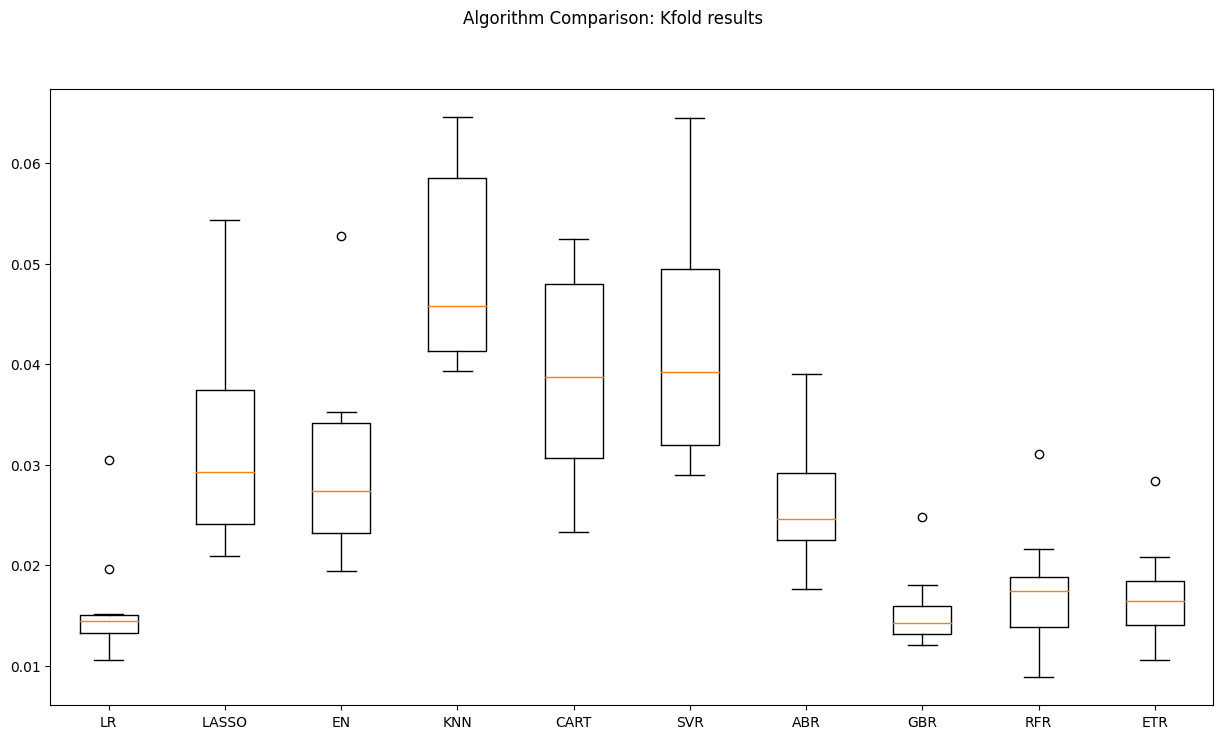

In [61]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

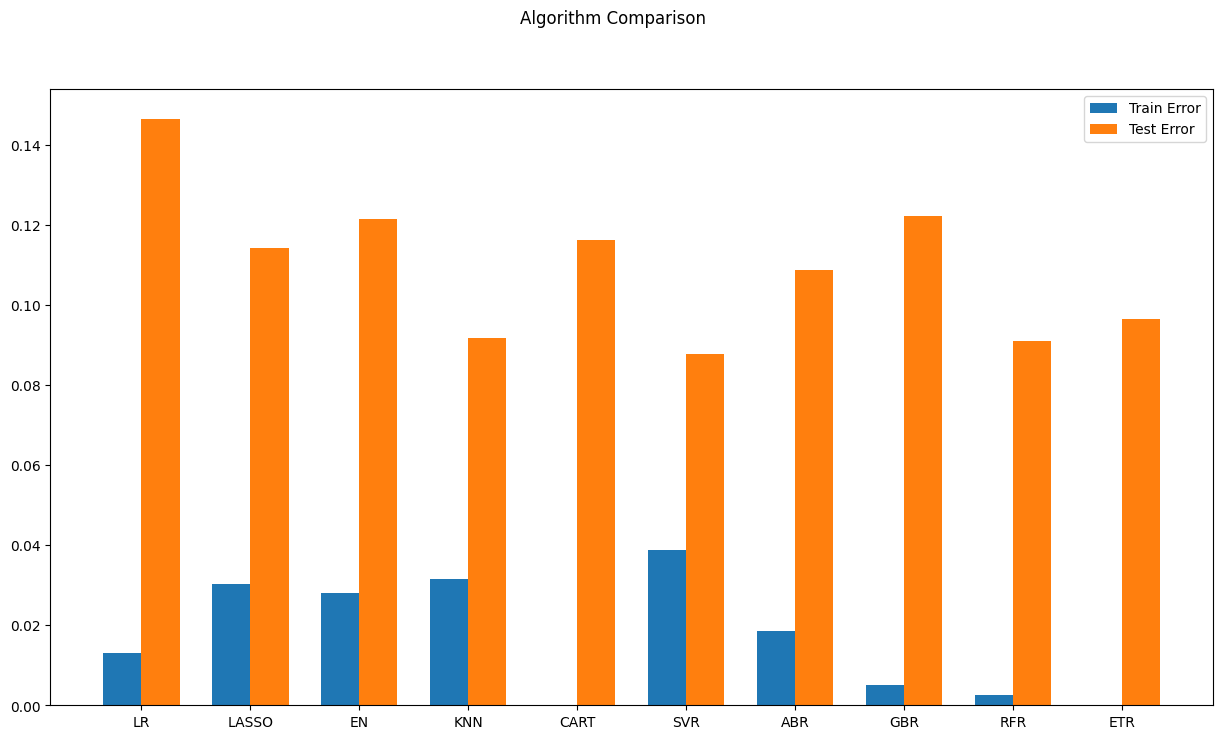

In [62]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()